# Trabajo Práctico Nº2: Redes Neuronales Recurrentes

## Alumno: Matías Amestoy

En primer lugar, se importan las librerías necesarias para realizar ambos ejercicios del TP:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import time
import seaborn as sns
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

%matplotlib inline

## Ejercicio 1

Se carga la información descargada para la acción de Loma Negra disponible en Yahoo.

In [50]:
data_ln = pd.read_csv("LOMA.csv")
data_ln.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-01,21.650000,22.150000,21.25,21.350000,21.350000,18872200
1,2017-11-02,21.100000,21.650000,21.00,21.510000,21.510000,1508800
2,2017-11-03,21.510000,22.150000,21.40,21.500000,21.500000,1790200
3,2017-11-06,21.760000,21.879999,21.41,21.629999,21.629999,718400
4,2017-11-07,21.639999,21.660000,21.00,21.190001,21.190001,1556500


In [51]:
data_ln.shape

(1021, 7)

In [52]:
data_ln.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1.021000e+03
mean,9.456152,9.671554,9.215301,9.435573,9.435573,4.580179e+05
std,5.519186,5.610053,5.410162,5.501327,5.501327,8.197786e+05
min,3.230000,3.380000,3.010000,3.210000,3.210000,4.330000e+04
25%,5.750000,5.900000,5.610000,5.760000,5.760000,1.953000e+05
50%,7.220000,7.360000,7.080000,7.220000,7.220000,3.001000e+05
75%,11.300000,11.640000,11.060000,11.300000,11.300000,4.987000e+05
max,25.410000,26.889999,24.490000,25.020000,25.020000,1.887220e+07


In [53]:
data_ln.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

Se eliminan posibles datos faltantes, se formatean las fechas y se grafica el valor de cierre de la acción para cada día en la serie descargada.

In [54]:
data_ln = data_ln.dropna()
data_ln.shape

(1021, 7)

In [55]:
print("Fecha inicial: {}\nÚltima fecha: {}".format(data_ln['Date'].min(), data_ln['Date'].max()))

Fecha inicial: 2017-11-01
Última fecha: 2021-11-19


(array([17532., 17713., 17897., 18078., 18262., 18444., 18628., 18809.,
        18993.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

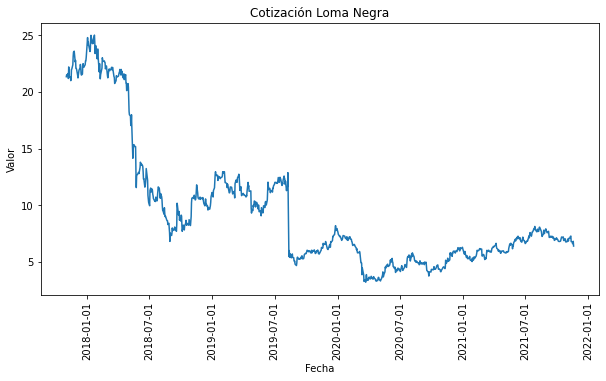

In [56]:
fmt = mdates.DateFormatter('%Y-%m-%d')
x_date = [datetime.datetime.strptime(i, '%Y-%m-%d') for i in data_ln.Date]

fig, ax = plt.subplots(figsize=(10,5))
ax.xaxis.set_major_formatter(fmt)
ax.plot(x_date, data_ln.Close)
ax.set_title('Cotización Loma Negra')
ax.set_ylabel('Valor')
ax.set_xlabel('Fecha')
plt.xticks(rotation=90)

Antes de comenzar con el entrenamiento de la red, se dividen los datos en un dataset de entrenamiento y otro de testeo.

In [57]:
def split_data(train_data, test_data, lookback):
    data_raw_train = train_data.to_numpy()
    data_train = []
    data_raw_test = test_data.to_numpy()
    data_test = []
    
    # se crean todas las posibles secuencias de la longitud de la secuencia
    for index in range(len(data_raw_train) - lookback): 
        data_train.append(data_raw_train[index: index + lookback])
    
    for index in range(len(data_raw_test) - lookback): 
        data_test.append(data_raw_test[index: index + lookback])
    
    data_train = np.array(data_train);
    data_test = np.array(data_test)
    
    x_train = data_train[:,:-1,:]
    y_train = data_train[:,-1,:]
    
    x_test = data_test[:,:-1]
    y_test = data_test[:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [58]:
price = data_ln[['Close']]
x_train, x_test, y_train, y_test = train_test_split(price.index.values, price.values, test_size=0.2, shuffle=False)
x_train.shape

(816,)

Se escalan los datos de entrenamiento transformándolos para valores entre -1 y 1. Los datos se dividieron antes para no transformar los datasets de entrenamiento y testeo juntos, lo que hubiera resultado en data leakeage.

In [59]:
scaler = MinMaxScaler(feature_range=(-1, 1))
x_train = scaler.fit_transform(x_train.reshape(-1,1))
y_train = scaler.fit_transform(y_train)
x_train = x_train.flatten()
x_test = scaler.transform(x_test.reshape(-1,1))
y_test = scaler.transform(y_test)
x_test = x_test.flatten()

In [60]:
df_train = pd.DataFrame(data=y_train, index=x_train)
df_test = pd.DataFrame(data=y_test, index=x_test)
df_train

x_train, y_train, x_test, y_test = split_data(df_train, df_test, 5)
x_test.shape

(200, 4, 1)

In [61]:
x_train.shape

(811, 4, 1)

In [62]:
x_test.shape

(200, 4, 1)

In [63]:
y_train.shape

(811, 1)

In [64]:
y_test.shape

(200, 1)

Se transforman los sets de entrenamiento y testeo a tensores de pytorch para poder cargarlos al modelo.

In [65]:
x_train_rnn = torch.from_numpy(x_train).type(torch.Tensor)
x_test_rnn = torch.from_numpy(x_test).type(torch.Tensor)

y_train_rnn = torch.from_numpy(y_train).type(torch.Tensor)
y_test_rnn = torch.from_numpy(y_test).type(torch.Tensor)

Se define el modelo de la red neuronal recurrente. Se permite especificar las dimensiones de entrada, de salida, la cantidad de estados ocultos y de capas, además de la probabilidad de dropout para la regularización.

In [66]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob=0):
        super(RNNModel, self).__init__()

        # definicion del numero de capas y nos por cada una
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # capas rnn
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # capa fc
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0):
        # inicializacion del estado oculto con zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Propagación hacia adelante pasando la entrada y el estado oculto al modelo
        out, h0 = self.rnn(x, h0.detach()) # detach devuelve un nuevo tensor que no requiere gradiente

        # reshape de output para conectar al fc
        out = out[:, -1, :]

        # convertir el estado final a la forma de salida deseada (batch_size, output_dim)
        out = self.fc(out)
        return out, h0

Se crea un modelo inicial para las pruebas con 32 estados ocultos y una sola capa. Las dimensiones de entrada y salida son una sola, puesto que para cada fecha el modelo debe dar un único valor de cierre de la acción. Como criterio de pérdida se usa el error cuadrático medio, y para la optimización se utiliza el algoritmo Adam con un learning rate default de 0,001 que no se cambiará durante el trabajo.

In [67]:
model = RNNModel(1, 32, 2, 1, 0)
print(model)

criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

torch.save(model,'modelRNN')

RNNModel(
  (rnn): RNN(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


Se define una función de reseteo del modelo para reiniciar los parámetros de la red al variar alguna de las características (número de estados ocultos, capas, tamaño de la ventana de datos) y la función de entrenamiento. También una función de ajuste que grafica los datos originales y la predicción del modelo una vez entrenado.

In [68]:
def model_reset(model):
    
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [69]:
def train():
    hist = np.zeros(num_epochs)
    hidden = None
    start_time = time.time()
    lstm = []
    h0 = torch.zeros(num_layers, window, hidden_dim).requires_grad_()
    for t in range(num_epochs):
        y_train_pred, h0 = model(x_train_rnn, h0)

        loss = criterion(y_train_pred, y_train_rnn)
        print("Epoch ", t, "MSE: ", loss.item())
        hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    
    
    ax.plot(hist);
    ax.set_xlabel('Epocas')
    ax.set_ylabel('Loss')
    training_time = time.time()-start_time
    print("Training time: {}".format(training_time))
    return y_train_pred

In [70]:
def model_adjust():
    predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
    original = pd.DataFrame(scaler.inverse_transform(y_train_rnn.detach().numpy()))
      
    ax1.plot(original.index, original[0], c='b')
    ax1.plot(predict.index, predict[0], c='r')
    ax1.set_xlabel('Día')
    ax1.set_ylabel('Indice MERVAL Loma Negra')
    ax1.legend(labels=['original', 'predict'])


En primer lugar, se evalúa la influencia del número de estados ocultos en la bondad del ajuste. Como valores por defecto se usan dos capas, una ventana de 5 valores y 50 épocas de entrenamiento.

RNNModel(
  (rnn): RNN(1, 8, num_layers=2, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)
TRAINING FOR 8 HIDDEN STATES
Epoch  0 MSE:  0.5563090443611145
Epoch  1 MSE:  0.5367134213447571
Epoch  2 MSE:  0.5177381038665771
Epoch  3 MSE:  0.49939748644828796
Epoch  4 MSE:  0.4817081689834595
Epoch  5 MSE:  0.46468570828437805
Epoch  6 MSE:  0.4483424723148346
Epoch  7 MSE:  0.432685911655426
Epoch  8 MSE:  0.4177187383174896
Epoch  9 MSE:  0.40343981981277466
Epoch  10 MSE:  0.38984543085098267
Epoch  11 MSE:  0.3769294321537018
Epoch  12 MSE:  0.3646835386753082
Epoch  13 MSE:  0.3530968725681305
Epoch  14 MSE:  0.3421558737754822
Epoch  15 MSE:  0.33184394240379333
Epoch  16 MSE:  0.3221416473388672
Epoch  17 MSE:  0.31302645802497864
Epoch  18 MSE:  0.30447304248809814
Epoch  19 MSE:  0.2964530885219574
Epoch  20 MSE:  0.28893598914146423
Epoch  21 MSE:  0.2818889915943146
Epoch  22 MSE:  0.2752777338027954
Epoch  23 MSE:  0.26906701922416687
Epoch  24 MSE

Epoch  5 MSE:  0.17286087572574615
Epoch  6 MSE:  0.1256445348262787
Epoch  7 MSE:  0.08739006519317627
Epoch  8 MSE:  0.06281827390193939
Epoch  9 MSE:  0.04301511123776436
Epoch  10 MSE:  0.019679205492138863
Epoch  11 MSE:  0.004113962408155203
Epoch  12 MSE:  0.019385244697332382
Epoch  13 MSE:  0.04348107799887657
Epoch  14 MSE:  0.04086771607398987
Epoch  15 MSE:  0.031883977353572845
Epoch  16 MSE:  0.027103440836071968
Epoch  17 MSE:  0.018628906458616257
Epoch  18 MSE:  0.008295832201838493
Epoch  19 MSE:  0.0032337878365069628
Epoch  20 MSE:  0.005534125026315451
Epoch  21 MSE:  0.011132133193314075
Epoch  22 MSE:  0.015145925804972649
Epoch  23 MSE:  0.01620768941938877
Epoch  24 MSE:  0.015678100287914276
Epoch  25 MSE:  0.014830210246145725
Epoch  26 MSE:  0.013604125007987022
Epoch  27 MSE:  0.011322777718305588
Epoch  28 MSE:  0.007971120066940784
Epoch  29 MSE:  0.004697109572589397
Epoch  30 MSE:  0.003044758690521121
Epoch  31 MSE:  0.00350248534232378
Epoch  32 MSE: 

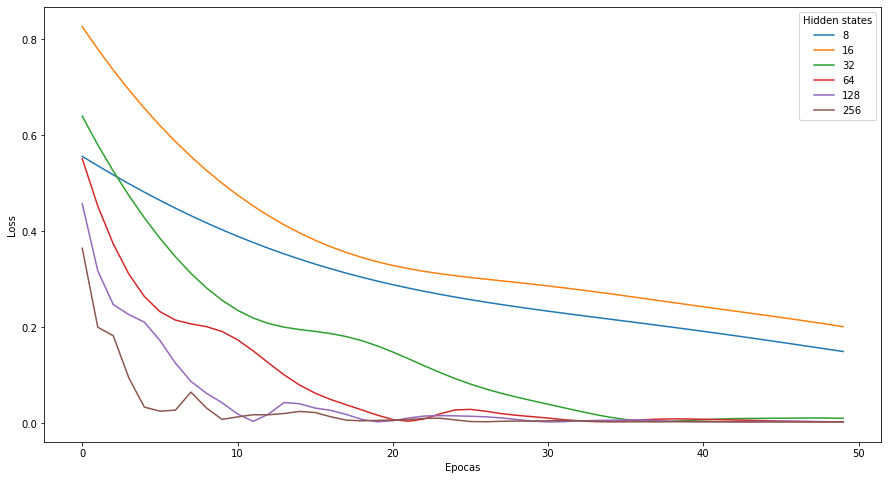

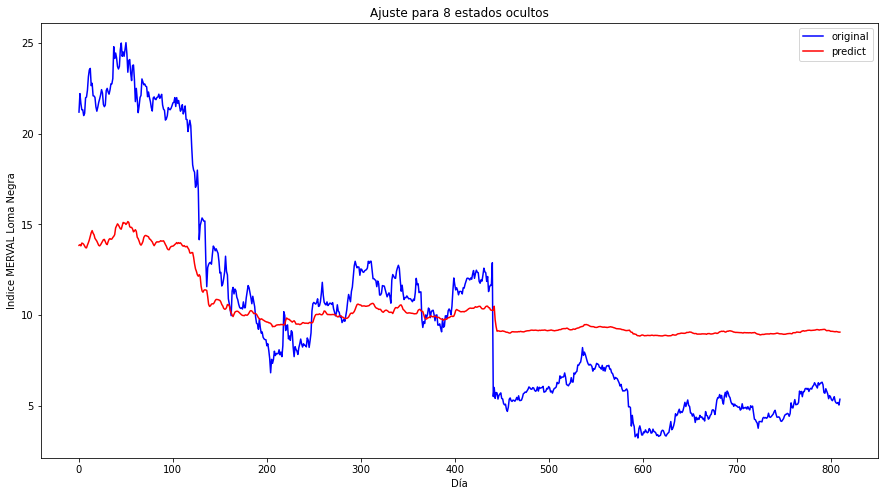

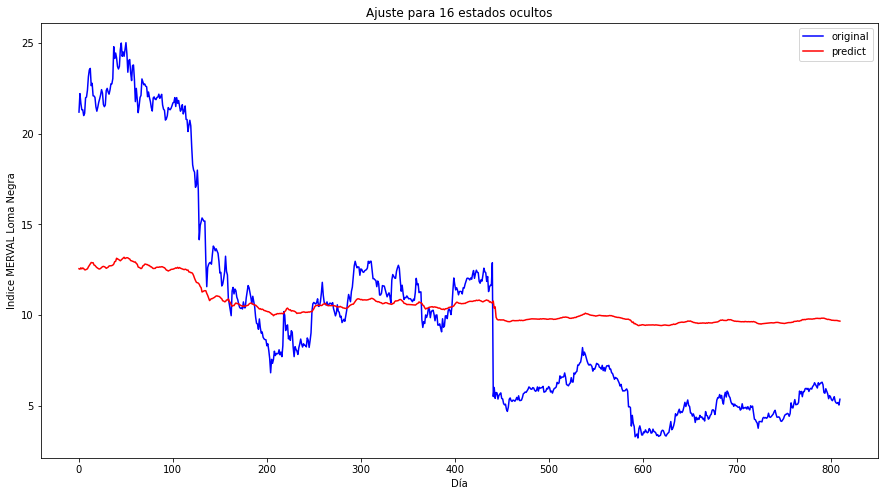

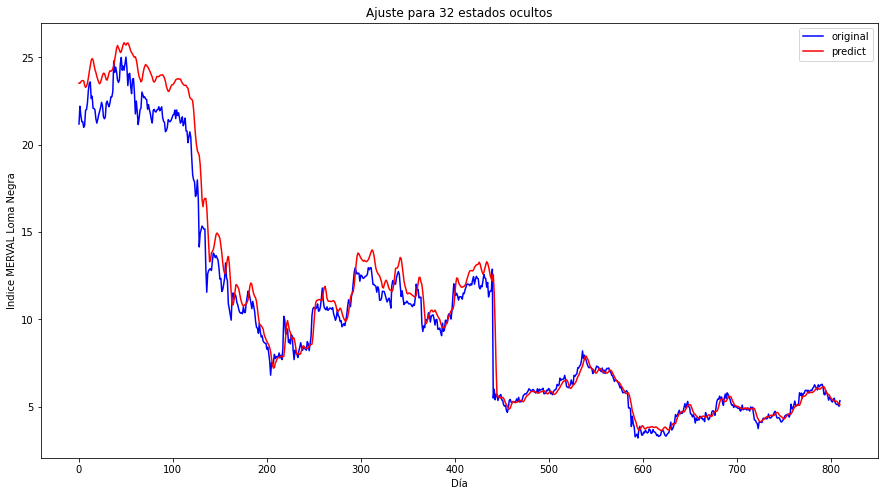

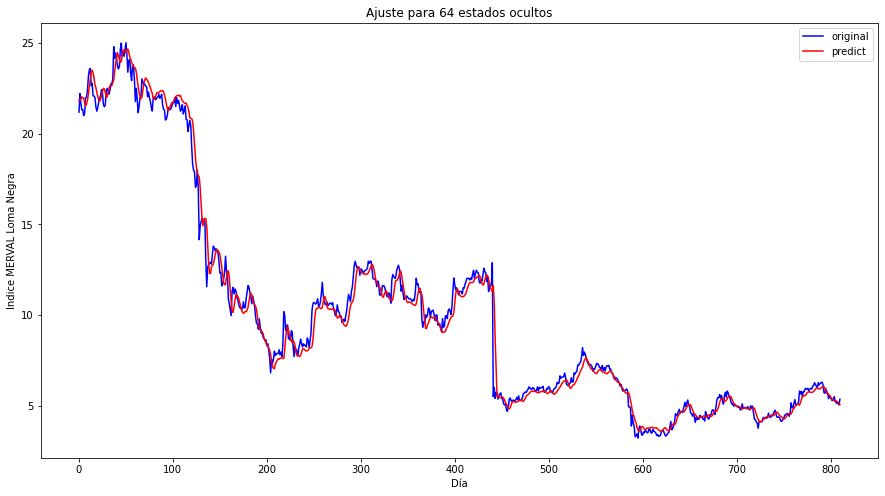

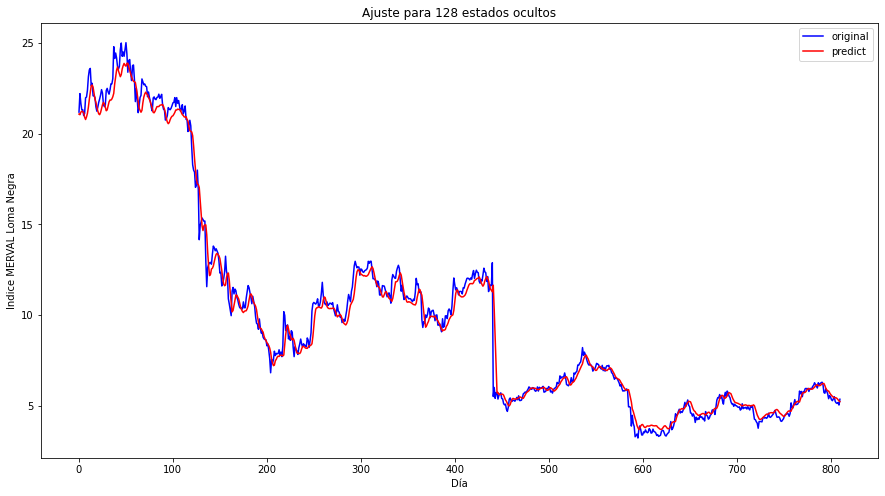

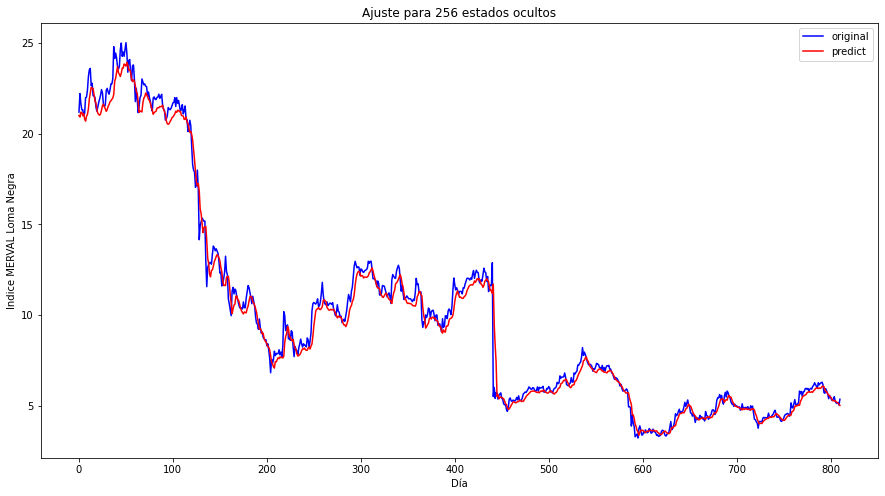

In [71]:
input_dim = 1
num_layers = 2
output_dim = 1
num_epochs = 50
window = 5

h_dims = [8, 16, 32, 64, 128, 256]
fig, ax = plt.subplots(figsize=(15,8))

for dim in h_dims:
    hidden_dim = dim
    model_reset(model)
    model = RNNModel(input_dim, hidden_dim, num_layers, output_dim, 0)
    print(model)
    print('TRAINING FOR {} HIDDEN STATES'.format(model.hidden_dim))


    criterion = torch.nn.MSELoss()
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    y_train_pred = train()
    fig, ax1 = plt.subplots(figsize=(15,8))
    ax1.set_title('Ajuste para {} estados ocultos'.format(model.hidden_dim))
    model_adjust()
ax.legend(title="Hidden states", labels=h_dims)

De los datos y gráficos obtenidos, se aprecia que la función pérdida para una dada época disminuye con la cantidad de estados ocultos. Por ello, en este caso el mejor ajuste se consigue con 256 estados ocultos (el mayor valor probado).

Se repite el proceso de prueba estudiando la influencia del tamaño de ventana en la pérdida del entrenamiento. Se fija el valor de 32 estados ocultos para todas las pruebas.

RNNModel(
  (rnn): RNN(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
TRAINING FOR 2 POINTS
Epoch  0 MSE:  0.5336956977844238
Epoch  1 MSE:  0.5079795122146606
Epoch  2 MSE:  0.4833754599094391
Epoch  3 MSE:  0.4598771035671234
Epoch  4 MSE:  0.4374637007713318
Epoch  5 MSE:  0.4161132872104645
Epoch  6 MSE:  0.3958051800727844
Epoch  7 MSE:  0.3765215575695038
Epoch  8 MSE:  0.35824689269065857
Epoch  9 MSE:  0.3409680724143982
Epoch  10 MSE:  0.32467445731163025
Epoch  11 MSE:  0.30935734510421753
Epoch  12 MSE:  0.2950088083744049
Epoch  13 MSE:  0.28162088990211487
Epoch  14 MSE:  0.2691843807697296
Epoch  15 MSE:  0.25768762826919556
Epoch  16 MSE:  0.24711477756500244
Epoch  17 MSE:  0.23744434118270874
Epoch  18 MSE:  0.22864744067192078
Epoch  19 MSE:  0.2206859588623047
Epoch  20 MSE:  0.21351122856140137
Epoch  21 MSE:  0.20706342160701752
Epoch  22 MSE:  0.20127134025096893
Epoch  23 MSE:  0.19605354964733124
Epoch  24 MSE:

Epoch  8 MSE:  0.24060669541358948
Epoch  9 MSE:  0.22211505472660065
Epoch  10 MSE:  0.20803451538085938
Epoch  11 MSE:  0.19701644778251648
Epoch  12 MSE:  0.18733040988445282
Epoch  13 MSE:  0.1770966500043869
Epoch  14 MSE:  0.16473710536956787
Epoch  15 MSE:  0.14942845702171326
Epoch  16 MSE:  0.13137611746788025
Epoch  17 MSE:  0.11180860549211502
Epoch  18 MSE:  0.09266933798789978
Epoch  19 MSE:  0.07600865513086319
Epoch  20 MSE:  0.06294219940900803
Epoch  21 MSE:  0.052355244755744934
Epoch  22 MSE:  0.041531987488269806
Epoch  23 MSE:  0.029301704838871956
Epoch  24 MSE:  0.01767105609178543
Epoch  25 MSE:  0.01037680171430111
Epoch  26 MSE:  0.00965031236410141
Epoch  27 MSE:  0.013562051579356194
Epoch  28 MSE:  0.017653698101639748
Epoch  29 MSE:  0.0198502317070961
Epoch  30 MSE:  0.021719269454479218
Epoch  31 MSE:  0.024762393906712532
Epoch  32 MSE:  0.027010492980480194
Epoch  33 MSE:  0.025794997811317444
Epoch  34 MSE:  0.021697798743844032
Epoch  35 MSE:  0.0172

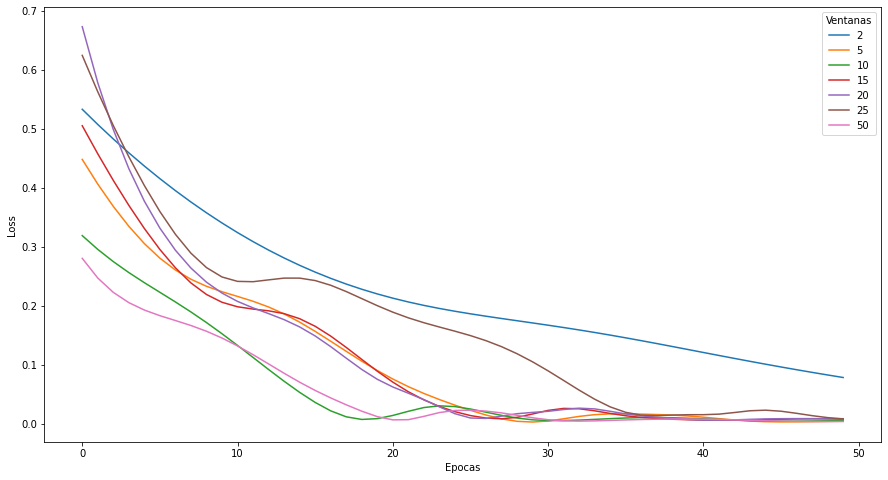

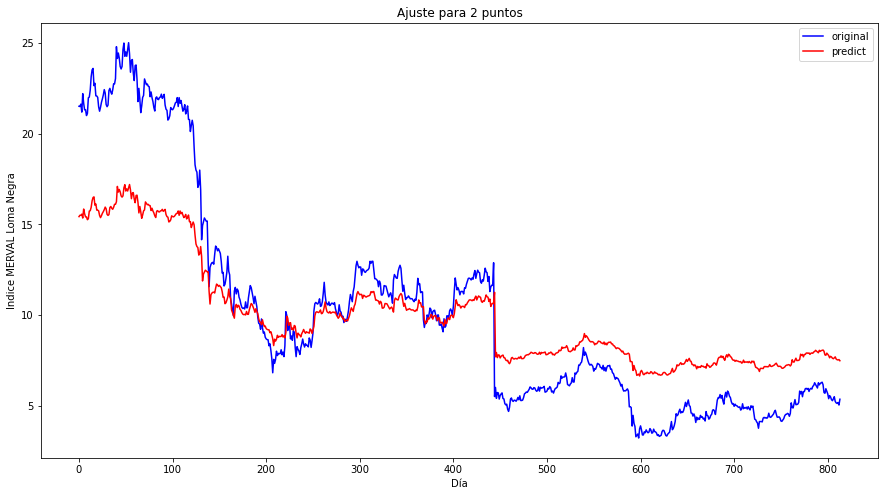

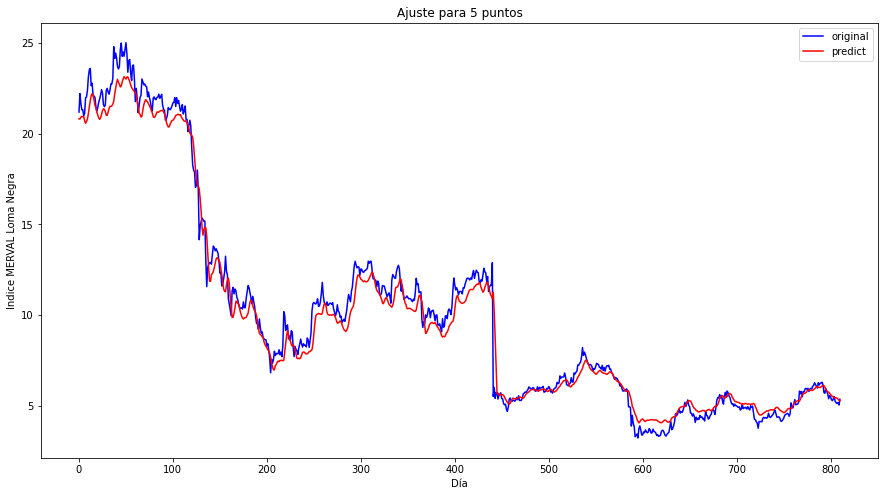

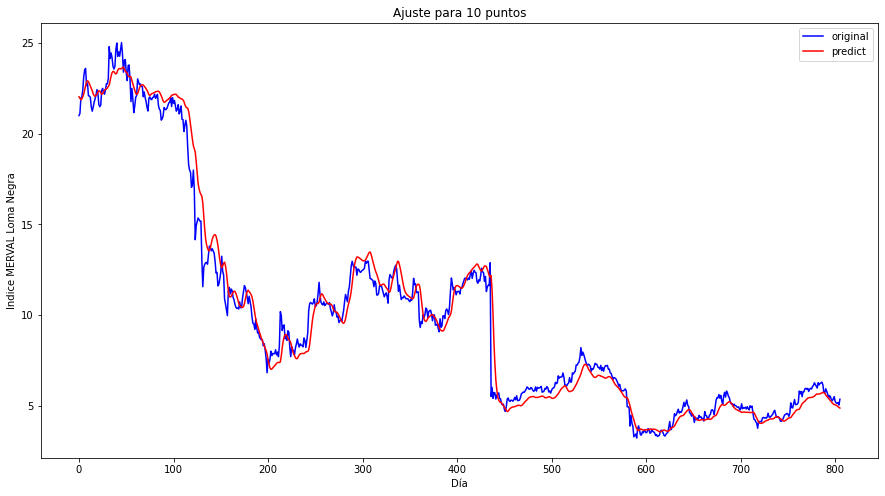

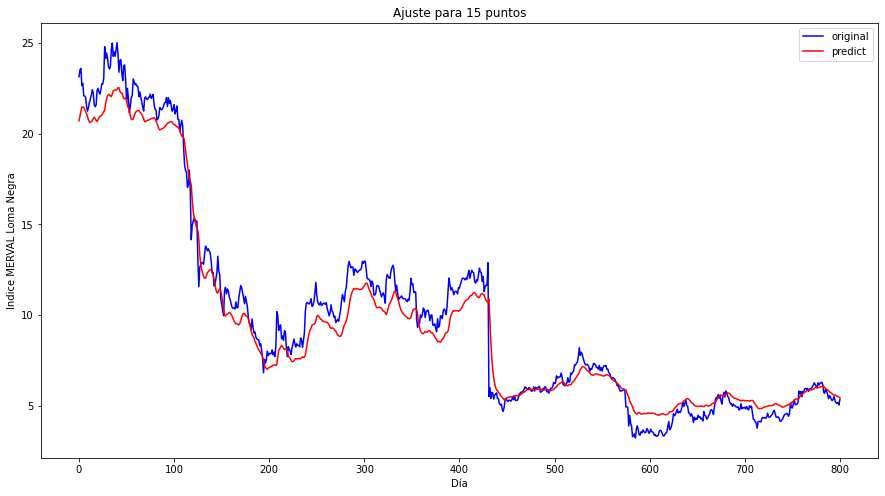

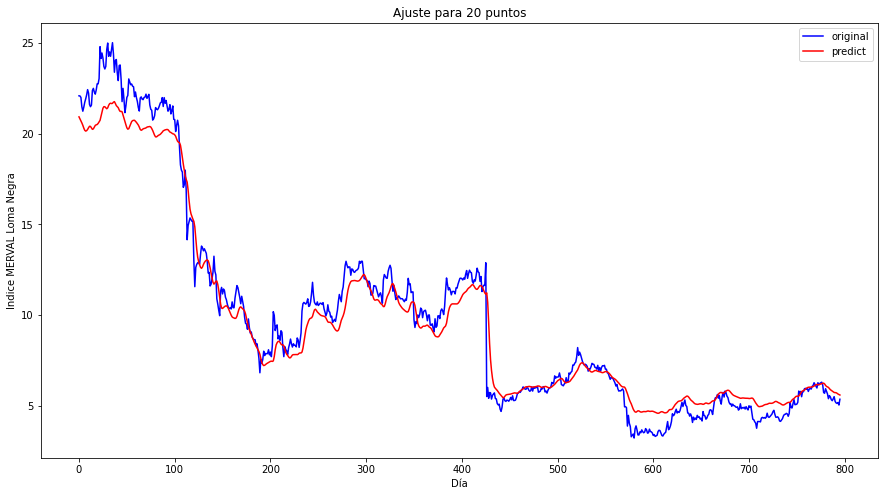

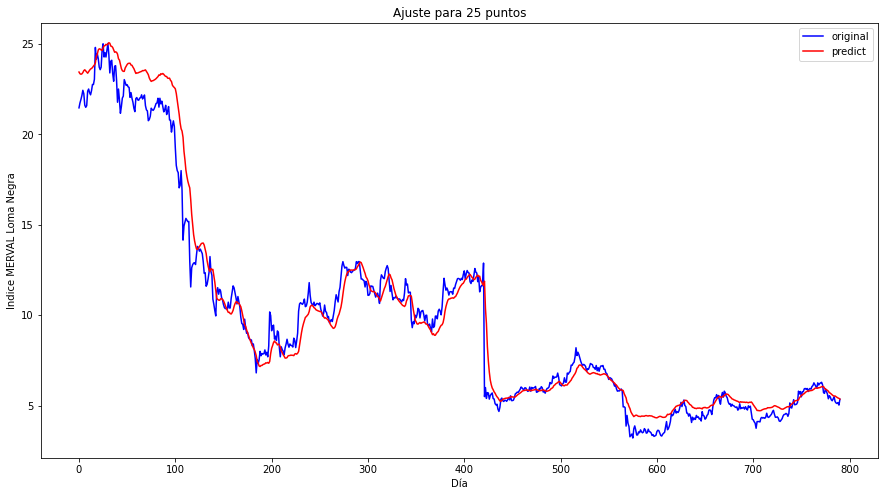

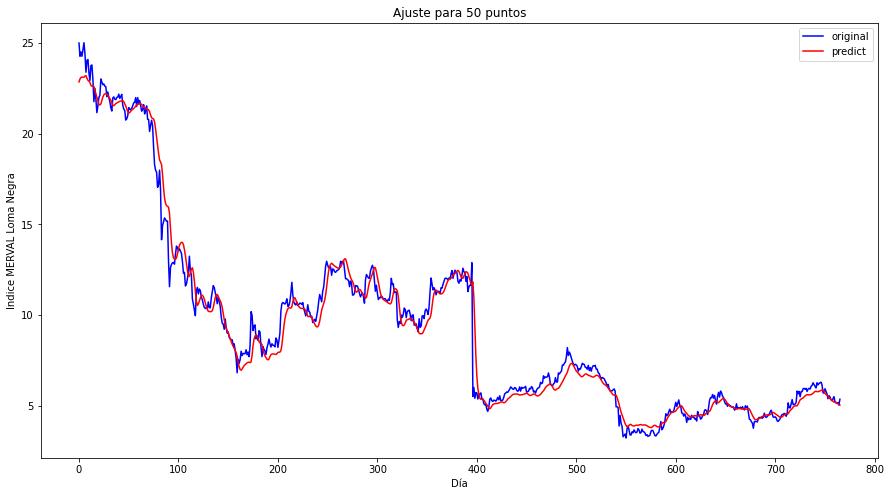

In [72]:
input_dim = 1
num_layers = 2
hidden_dim = 32
output_dim = 1
num_epochs = 50

windows = [2, 5, 10, 15, 20, 25, 50]
fig, ax = plt.subplots(figsize=(15,8))

for w in windows:
    window = w
    x_train, y_train, x_test, y_test = split_data(df_train, df_test, w)
    x_train_rnn = torch.from_numpy(x_train).type(torch.Tensor)
    x_test_rnn = torch.from_numpy(x_test).type(torch.Tensor)
    y_train_rnn = torch.from_numpy(y_train).type(torch.Tensor)
    y_test_rnn = torch.from_numpy(y_test).type(torch.Tensor)
    model_reset(model)
    model = RNNModel(input_dim, hidden_dim, num_layers, output_dim, 0)
    print(model)
    print('TRAINING FOR {} POINTS'.format(w))

    criterion = torch.nn.MSELoss()
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    y_train_pred = train()
    fig, ax1 = plt.subplots(figsize=(15,8))
    ax1.set_title('Ajuste para {} puntos'.format(w))
    model_adjust()
ax.legend(title="Ventanas", labels=windows)

En este caso, incrementar la ventana de datos no da siempre un beneficio claro, las curvas evolucionan en forma bastante similar al usar más de dos datos, y el valor óptimo de pérdida se obtiene con w=10 en una menor cantidad de épocas. Además, ventanas mayores implican tiempos de entrenamiento mucho más largos y por ende un costo computacional significativamente mayor.

Por último, se repite el procedimiento variando el número de capas.

RNNModel(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
TRAINING FOR RECURRENT LAYERS = 1
Epoch  0 MSE:  0.27678215503692627
Epoch  1 MSE:  0.26147377490997314
Epoch  2 MSE:  0.24751104414463043
Epoch  3 MSE:  0.2348710149526596
Epoch  4 MSE:  0.22348663210868835
Epoch  5 MSE:  0.21326448023319244
Epoch  6 MSE:  0.20410683751106262
Epoch  7 MSE:  0.19590315222740173
Epoch  8 MSE:  0.1885104477405548
Epoch  9 MSE:  0.18174105882644653
Epoch  10 MSE:  0.17536920309066772
Epoch  11 MSE:  0.16915777325630188
Epoch  12 MSE:  0.16289344429969788
Epoch  13 MSE:  0.15641586482524872
Epoch  14 MSE:  0.14962968230247498
Epoch  15 MSE:  0.14250043034553528
Epoch  16 MSE:  0.1350410431623459
Epoch  17 MSE:  0.12729433178901672
Epoch  18 MSE:  0.11931484937667847
Epoch  19 MSE:  0.11115240305662155
Epoch  20 MSE:  0.10284006595611572
Epoch  21 MSE:  0.09438936412334442
Epoch  22 MSE:  0.0857928991317749
Epoch  23 MSE:  0.07703367620706558
Epoch  2

Epoch  2 MSE:  0.2551313042640686
Epoch  3 MSE:  0.23053033649921417
Epoch  4 MSE:  0.23692819476127625
Epoch  5 MSE:  0.24917517602443695
Epoch  6 MSE:  0.2513943016529083
Epoch  7 MSE:  0.24494874477386475
Epoch  8 MSE:  0.2362528294324875
Epoch  9 MSE:  0.23071758449077606
Epoch  10 MSE:  0.2307138741016388
Epoch  11 MSE:  0.23472416400909424
Epoch  12 MSE:  0.23860488831996918
Epoch  13 MSE:  0.2394704818725586
Epoch  14 MSE:  0.2373943328857422
Epoch  15 MSE:  0.23407308757305145
Epoch  16 MSE:  0.2312871217727661
Epoch  17 MSE:  0.23006005585193634
Epoch  18 MSE:  0.2304360419511795
Epoch  19 MSE:  0.23171499371528625
Epoch  20 MSE:  0.2329532653093338
Epoch  21 MSE:  0.23346413671970367
Epoch  22 MSE:  0.23307402431964874
Epoch  23 MSE:  0.2320697009563446
Epoch  24 MSE:  0.23095537722110748
Epoch  25 MSE:  0.2301836907863617
Epoch  26 MSE:  0.22997210919857025
Epoch  27 MSE:  0.2302529513835907
Epoch  28 MSE:  0.23075264692306519
Epoch  29 MSE:  0.23114746809005737
Epoch  30 MS

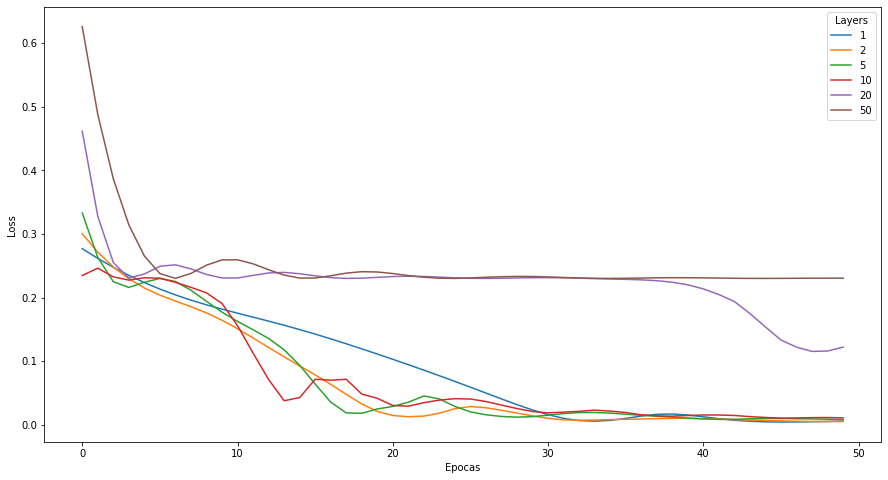

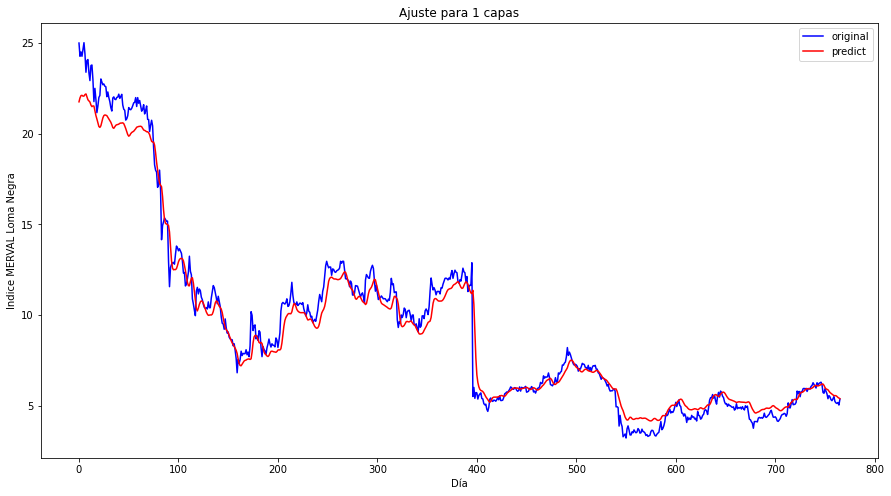

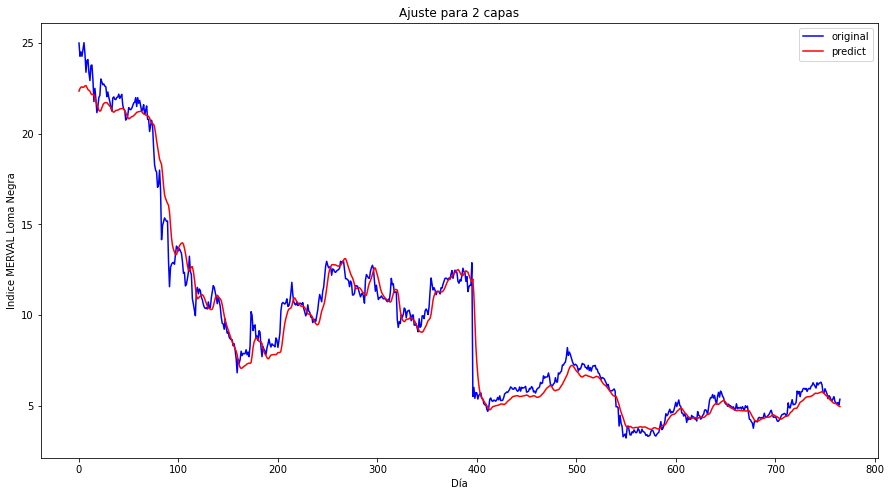

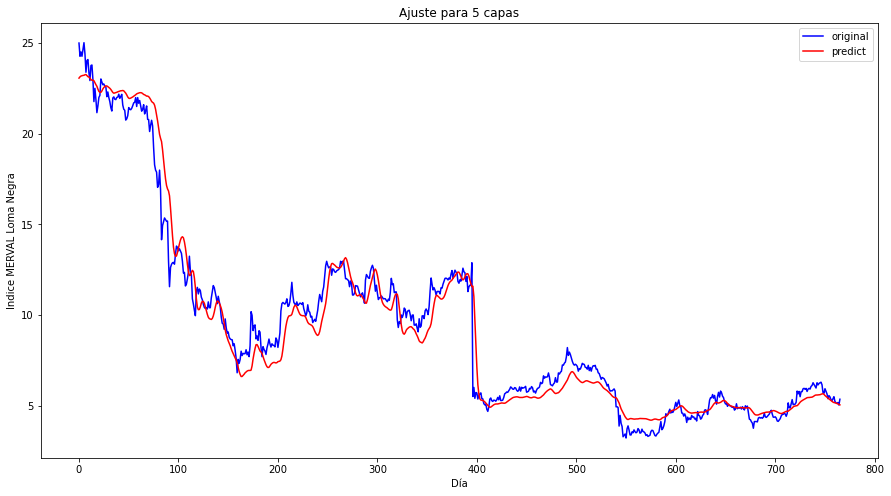

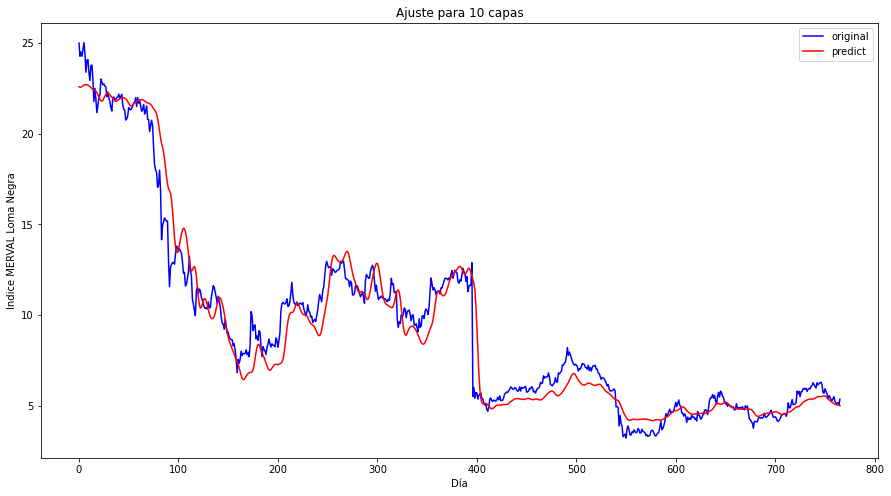

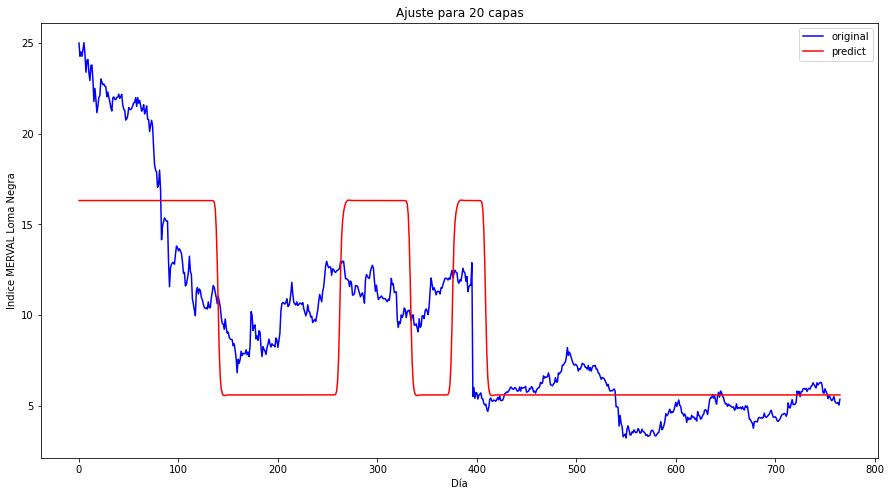

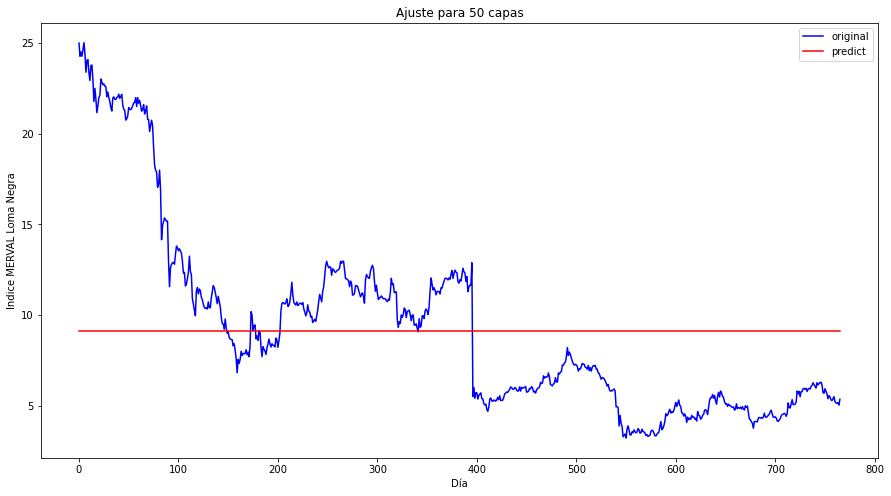

In [73]:
input_dim = 1
hidden_dim = 32
output_dim = 1
num_epochs = 50
window = 5

n_layers = [1, 2, 5, 10, 20, 50]
fig, ax = plt.subplots(figsize=(15,8))

for layer in n_layers:
    layer_dim = layer
    model_reset(model)
    model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim, 0)
    print(model)
    print('TRAINING FOR RECURRENT LAYERS = {}'.format(layer))


    criterion = torch.nn.MSELoss()
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    y_train_pred = train()
    fig, ax1 = plt.subplots(figsize=(15,8))
    ax1.set_title('Ajuste para {} capas'.format(layer))
    model_adjust()
ax.legend(title="Layers", labels=n_layers)

En este caso, se observa nuevamente que un incremento en la cantidad de capas no redunda en una mejora de la estimación en todos los casos e incrementa mucho el tiempo de procesamiento. En particular, se obtuvo el mejor resultado para 2 capas en la red.

Se crea entonces el modelo de RNN definitivo según la optimización de parámetros realizada y se entrena.

In [75]:
input_dim = 1
num_layers = 2
hidden_dim = 256
output_dim = 1
num_epochs = 200
window = 10

x_train, y_train, x_test, y_test = split_data(df_train, df_test, window)
x_train_rnn = torch.from_numpy(x_train).type(torch.Tensor)
x_test_rnn = torch.from_numpy(x_test).type(torch.Tensor)
y_train_rnn = torch.from_numpy(y_train).type(torch.Tensor)
y_test_rnn = torch.from_numpy(y_test).type(torch.Tensor)

model = RNNModel(input_dim, hidden_dim, num_layers, output_dim, 0)
model_reset(model)
print(model)
criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.0001)

RNNModel(
  (rnn): RNN(1, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


Epoch  0 MSE:  0.37690773606300354
Epoch  1 MSE:  0.3483034074306488
Epoch  2 MSE:  0.3226500451564789
Epoch  3 MSE:  0.2996983230113983
Epoch  4 MSE:  0.27928391098976135
Epoch  5 MSE:  0.26127639412879944
Epoch  6 MSE:  0.2455410212278366
Epoch  7 MSE:  0.2318846434354782
Epoch  8 MSE:  0.21998454630374908
Epoch  9 MSE:  0.20932547748088837
Epoch  10 MSE:  0.19920358061790466
Epoch  11 MSE:  0.18884898722171783
Epoch  12 MSE:  0.17761585116386414
Epoch  13 MSE:  0.16512373089790344
Epoch  14 MSE:  0.15129373967647552
Epoch  15 MSE:  0.13629889488220215
Epoch  16 MSE:  0.12047327309846878
Epoch  17 MSE:  0.10421643406152725
Epoch  18 MSE:  0.08791884034872055
Epoch  19 MSE:  0.07192674279212952
Epoch  20 MSE:  0.05655374005436897
Epoch  21 MSE:  0.04213347285985947
Epoch  22 MSE:  0.02909472957253456
Epoch  23 MSE:  0.018041078001260757
Epoch  24 MSE:  0.009815567173063755
Epoch  25 MSE:  0.005489530507475138
Epoch  26 MSE:  0.0060710906982421875
Epoch  27 MSE:  0.011549639515578747
E

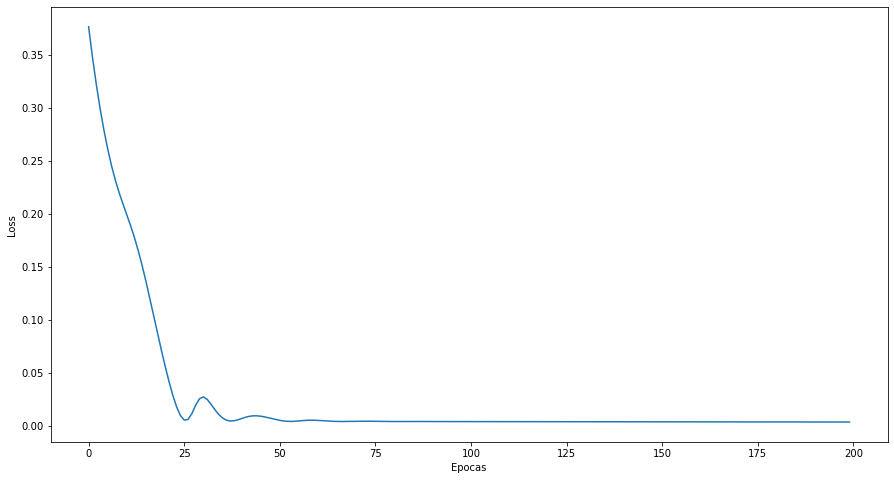

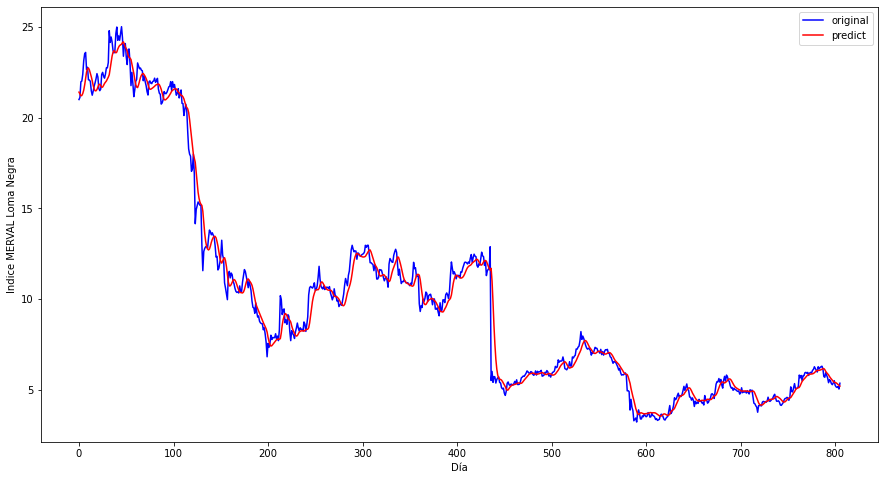

In [76]:
fig, ax = plt.subplots(figsize=(15,8))
y_train_pred = train()
fig, ax1 = plt.subplots(figsize=(15,8))
model_adjust()

In [77]:
h0 = torch.zeros(num_layers, window, hidden_dim).requires_grad_()
y_test_pred, _ = model(x_test_rnn, h0)
y_test_pred

tensor([[-0.7784],
        [-0.7689],
        [-0.7609],
        [-0.7538],
        [-0.7480],
        [-0.7431],
        [-0.7404],
        [-0.7387],
        [-0.7378],
        [-0.7439],
        [-0.7543],
        [-0.7636],
        [-0.7703],
        [-0.7759],
        [-0.7820],
        [-0.7897],
        [-0.7961],
        [-0.8010],
        [-0.8003],
        [-0.7922],
        [-0.7818],
        [-0.7713],
        [-0.7626],
        [-0.7558],
        [-0.7523],
        [-0.7514],
        [-0.7521],
        [-0.7528],
        [-0.7540],
        [-0.7534],
        [-0.7497],
        [-0.7439],
        [-0.7368],
        [-0.7304],
        [-0.7254],
        [-0.7203],
        [-0.7155],
        [-0.7098],
        [-0.7076],
        [-0.7098],
        [-0.7154],
        [-0.7230],
        [-0.7314],
        [-0.7376],
        [-0.7429],
        [-0.7465],
        [-0.7511],
        [-0.7540],
        [-0.7568],
        [-0.7575],
        [-0.7570],
        [-0.7554],
        [-0.

In [78]:
predict_test = pd.DataFrame(scaler.inverse_transform(y_test_pred.detach().numpy()))
predict_test


,0
0,5.626026
1,5.730510
2,5.817022
3,5.895086
4,5.958172
...,...
190,7.052974
191,7.039925
192,6.979539
193,6.881607


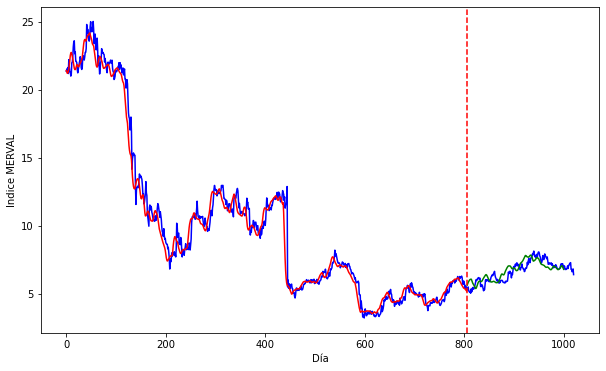

In [79]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_rnn.detach().numpy()))

fig, ax = plt.subplots(figsize=(10, 6))

# plt.plot(original.index, original[0], c='b')

plt.plot(data_ln.Close, c='b')
plt.plot(predict.index, predict[0], c='r')
plt.plot(np.arange(predict.index.max() + 1, predict.index.max() + 1 + len(predict_test)), predict_test[0], c='g')
plt.xlabel('Día')
plt.ylabel('Indice MERVAL');
plt.axvline(x=predict.index.max() + 1, c='r', linestyle='--'); # a donde arranca la prediccion

Se evalúa y se grafica entonces la predicción obtenida con la RNN.

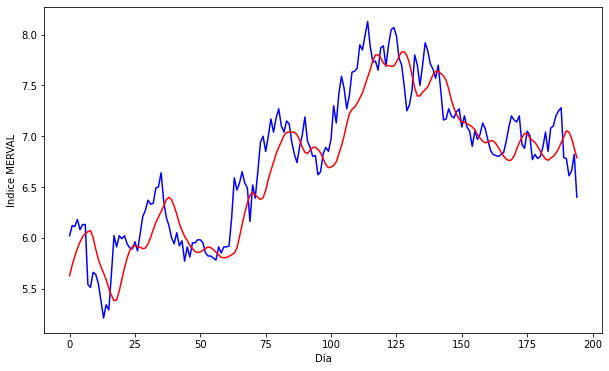

In [80]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.plot(data_ln.loc[len(data_ln)-len(predict_test):len(data_ln), 'Close'].reset_index(drop=True), c='b')
plt.plot(predict_test.index, predict_test[0], c='r')
plt.xlabel('Día')
plt.ylabel('Indice MERVAL');

## **LSTM**

Se repite el análisis previo con una red LSTM para comparar su rendimiento. Se definen la clase y la función de entrenamiento correspondientes.

In [81]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [82]:
def train_LSTM():
    hist = np.zeros(num_epochs)
    start_time = time.time()
    lstm = []
    for t in range(num_epochs):
        y_train_pred_lstm = model(x_train_lstm)

        loss = criterion(y_train_pred_lstm, y_train_lstm)
        print("Epoch ", t, "MSE: ", loss.item())
        hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    
    
    ax.plot(hist);
    ax.set_xlabel('Epocas')
    ax.set_ylabel('Loss')
    training_time = time.time()-start_time
    print("Training time: {}".format(training_time))
    return y_train_pred_lstm

In [83]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 50
window = 5

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
torch.save(model,'modelLSTM')

In [84]:
x_train, y_train, x_test, y_test = split_data(df_train, df_test, window)

x_train_lstm = torch.from_numpy(x_train).type(torch.Tensor)
x_test_lstm = torch.from_numpy(x_test).type(torch.Tensor)

y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

LSTM(
  (lstm): LSTM(1, 8, num_layers=2, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)
TRAINING FOR 8 HIDDEN STATES
Epoch  0 MSE:  0.5481628179550171
Epoch  1 MSE:  0.5417160391807556
Epoch  2 MSE:  0.5353339314460754
Epoch  3 MSE:  0.529017448425293
Epoch  4 MSE:  0.5227676033973694
Epoch  5 MSE:  0.5165850520133972
Epoch  6 MSE:  0.5104702115058899
Epoch  7 MSE:  0.5044234395027161
Epoch  8 MSE:  0.4984447658061981
Epoch  9 MSE:  0.4925340712070465
Epoch  10 MSE:  0.486690878868103
Epoch  11 MSE:  0.4809147119522095
Epoch  12 MSE:  0.47520479559898376
Epoch  13 MSE:  0.46956026554107666
Epoch  14 MSE:  0.4639802575111389
Epoch  15 MSE:  0.4584638774394989
Epoch  16 MSE:  0.453010231256485
Epoch  17 MSE:  0.44761836528778076
Epoch  18 MSE:  0.442287415266037
Epoch  19 MSE:  0.4370165467262268
Epoch  20 MSE:  0.4318048059940338
Epoch  21 MSE:  0.4266514480113983
Epoch  22 MSE:  0.4215554893016815
Epoch  23 MSE:  0.41651612520217896
Epoch  24 MSE:  0.41153

Epoch  8 MSE:  0.2853958308696747
Epoch  9 MSE:  0.2645058333873749
Epoch  10 MSE:  0.24526555836200714
Epoch  11 MSE:  0.22935226559638977
Epoch  12 MSE:  0.2188601791858673
Epoch  13 MSE:  0.21494492888450623
Epoch  14 MSE:  0.21515609323978424
Epoch  15 MSE:  0.21364204585552216
Epoch  16 MSE:  0.2061702311038971
Epoch  17 MSE:  0.19289129972457886
Epoch  18 MSE:  0.17663392424583435
Epoch  19 MSE:  0.1604405641555786
Epoch  20 MSE:  0.14619199931621552
Epoch  21 MSE:  0.13433636724948883
Epoch  22 MSE:  0.12429329007863998
Epoch  23 MSE:  0.11505454033613205
Epoch  24 MSE:  0.10566145181655884
Epoch  25 MSE:  0.095484159886837
Epoch  26 MSE:  0.08436755836009979
Epoch  27 MSE:  0.07271012663841248
Epoch  28 MSE:  0.06146024912595749
Epoch  29 MSE:  0.05189455673098564
Epoch  30 MSE:  0.04496001824736595
Epoch  31 MSE:  0.04027750715613365
Epoch  32 MSE:  0.03600943461060524
Epoch  33 MSE:  0.03074747882783413
Epoch  34 MSE:  0.02525305189192295
Epoch  35 MSE:  0.02150704711675644
E

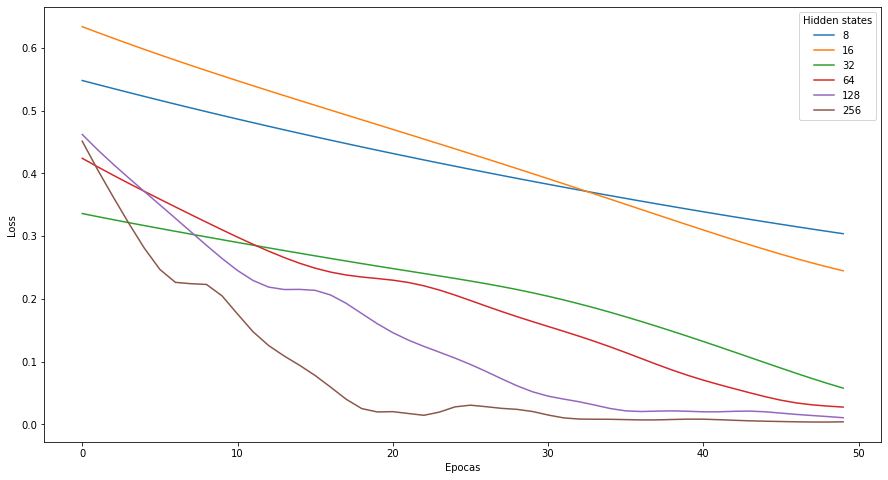

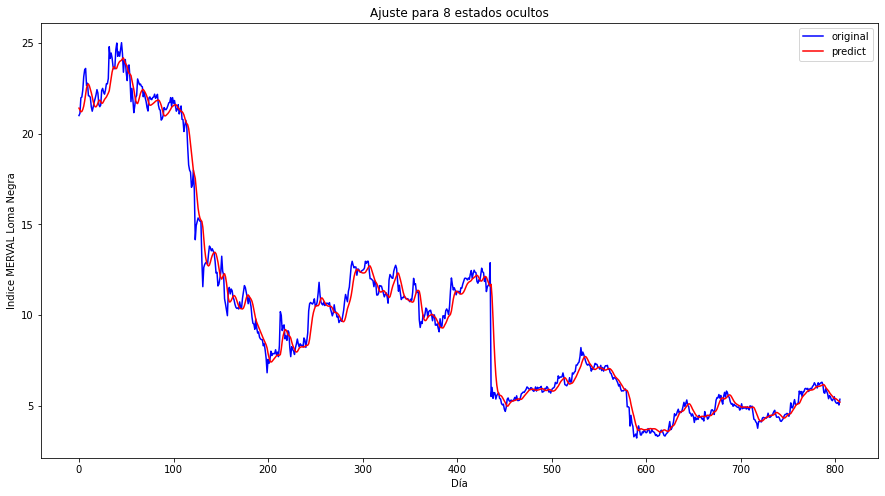

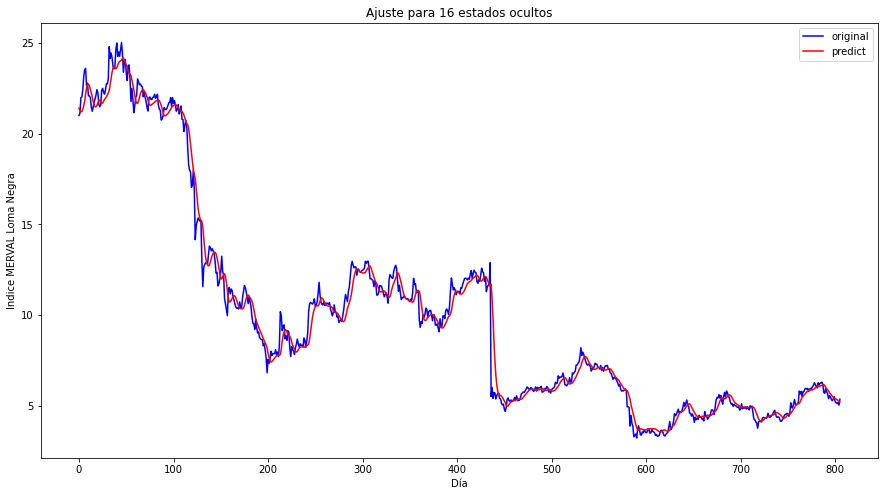

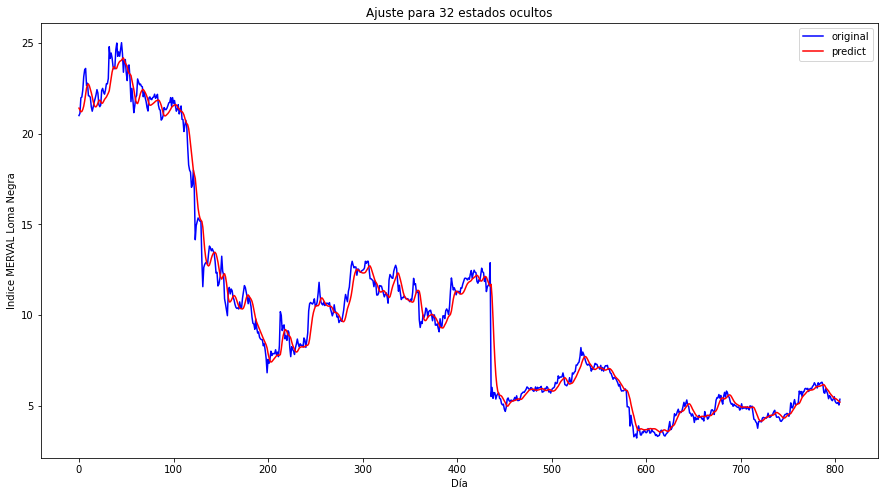

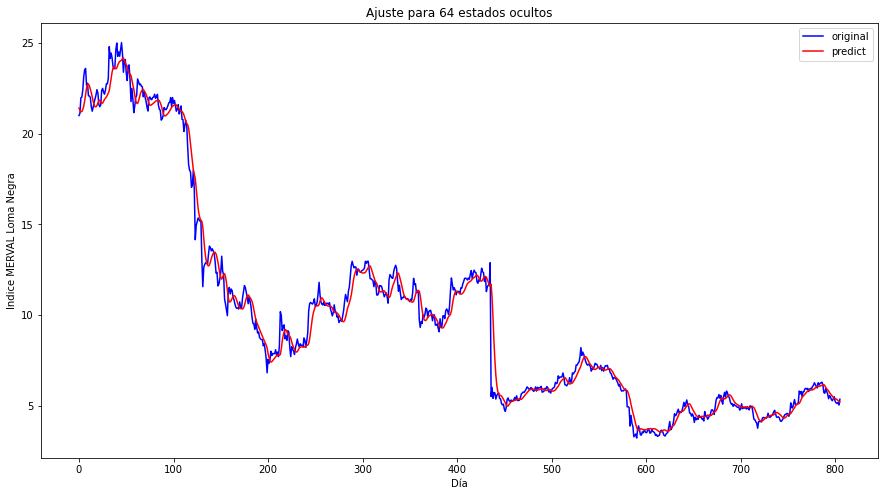

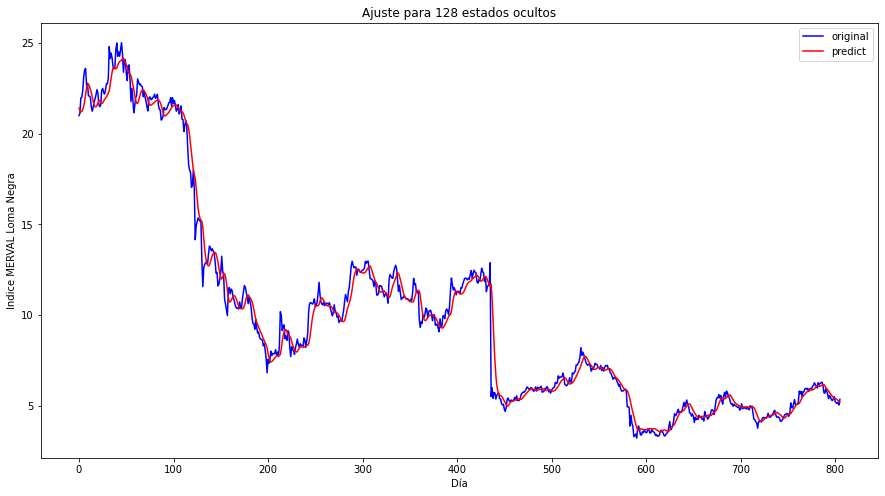

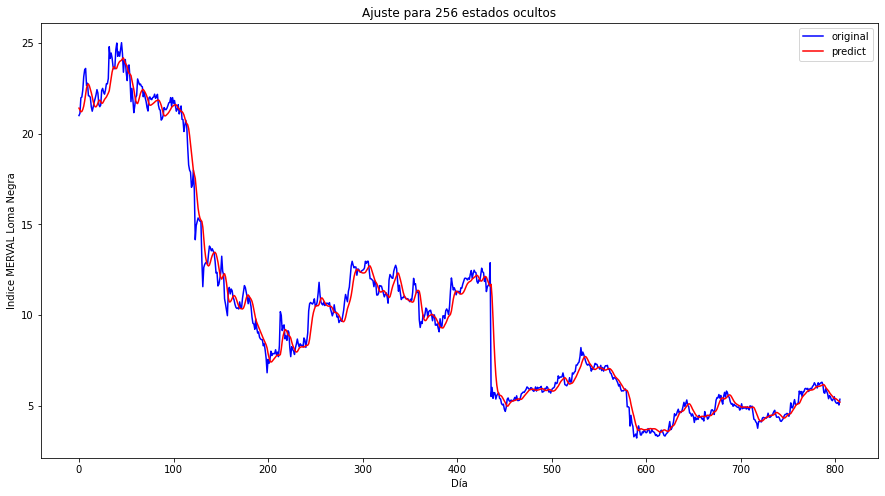

In [85]:
h_dims = [8, 16, 32, 64, 128, 256]
fig, ax = plt.subplots(figsize=(15,8))

for dim in h_dims:
    hidden_dim = dim
    model_reset(model)
    model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
    print(model)
    print('TRAINING FOR {} HIDDEN STATES'.format(model.hidden_dim))


    criterion = torch.nn.MSELoss()
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    y_train_pred_lstm = train_LSTM()
    fig, ax1 = plt.subplots(figsize=(15,8))
    ax1.set_title('Ajuste para {} estados ocultos'.format(model.hidden_dim))
    model_adjust()
ax.legend(title="Hidden states", labels=h_dims)

Nuevamente, los menores valores para la función pérdida se obtuvieron para una mayor cantidad de estados ocultos.

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
TRAINING FOR 2 POINTS
Epoch  0 MSE:  0.46902480721473694
Epoch  1 MSE:  0.4647742509841919
Epoch  2 MSE:  0.4605618417263031
Epoch  3 MSE:  0.45638716220855713
Epoch  4 MSE:  0.4522484242916107
Epoch  5 MSE:  0.4481430649757385
Epoch  6 MSE:  0.44406887888908386
Epoch  7 MSE:  0.440023809671402
Epoch  8 MSE:  0.43600568175315857
Epoch  9 MSE:  0.43201225996017456
Epoch  10 MSE:  0.4280409812927246
Epoch  11 MSE:  0.4240891635417938
Epoch  12 MSE:  0.420154333114624
Epoch  13 MSE:  0.4162338972091675
Epoch  14 MSE:  0.41232532262802124
Epoch  15 MSE:  0.40842634439468384
Epoch  16 MSE:  0.4045347273349762
Epoch  17 MSE:  0.4006482660770416
Epoch  18 MSE:  0.396764874458313
Epoch  19 MSE:  0.3928825259208679
Epoch  20 MSE:  0.38899925351142883
Epoch  21 MSE:  0.3851132392883301
Epoch  22 MSE:  0.3812227249145508
Epoch  23 MSE:  0.37732598185539246
Epoch  24 MSE:  0.3734

Epoch  10 MSE:  0.40561893582344055
Epoch  11 MSE:  0.3892659842967987
Epoch  12 MSE:  0.3726576864719391
Epoch  13 MSE:  0.355732798576355
Epoch  14 MSE:  0.3384384512901306
Epoch  15 MSE:  0.32073402404785156
Epoch  16 MSE:  0.30259761214256287
Epoch  17 MSE:  0.28403523564338684
Epoch  18 MSE:  0.26509442925453186
Epoch  19 MSE:  0.24588309228420258
Epoch  20 MSE:  0.2265973836183548
Epoch  21 MSE:  0.2075609415769577
Epoch  22 MSE:  0.1892777979373932
Epoch  23 MSE:  0.17249371111392975
Epoch  24 MSE:  0.15824079513549805
Epoch  25 MSE:  0.14779742062091827
Epoch  26 MSE:  0.14240029454231262
Epoch  27 MSE:  0.14246982336044312
Epoch  28 MSE:  0.14647144079208374
Epoch  29 MSE:  0.15068940818309784
Epoch  30 MSE:  0.15123827755451202
Epoch  31 MSE:  0.1465539187192917
Epoch  32 MSE:  0.1376028209924698
Epoch  33 MSE:  0.12654802203178406
Epoch  34 MSE:  0.11551523208618164
Epoch  35 MSE:  0.10593726485967636
Epoch  36 MSE:  0.09839779883623123
Epoch  37 MSE:  0.09279188513755798
Ep

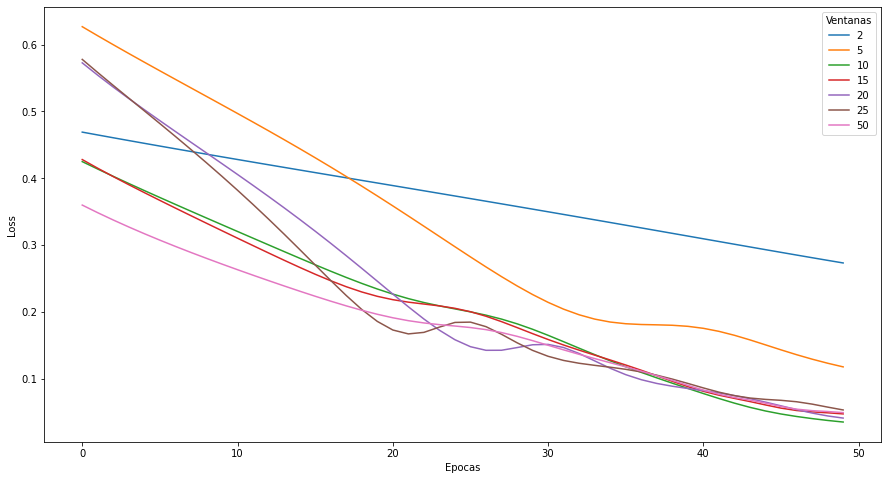

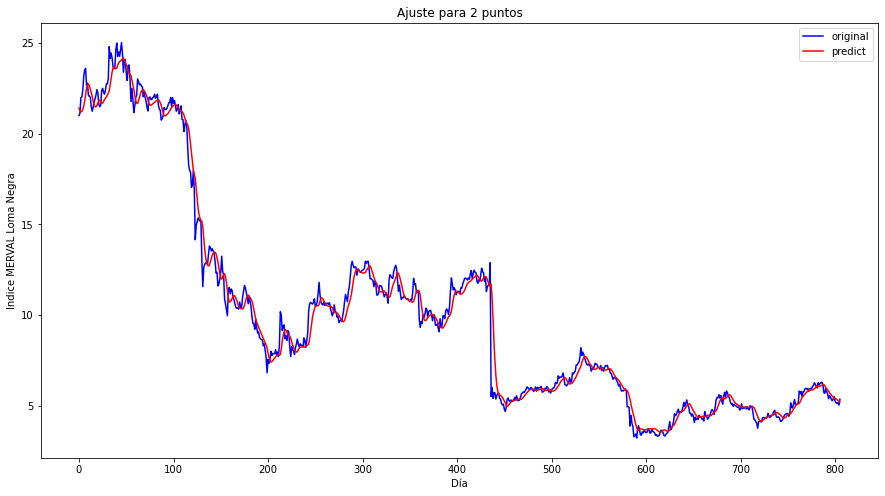

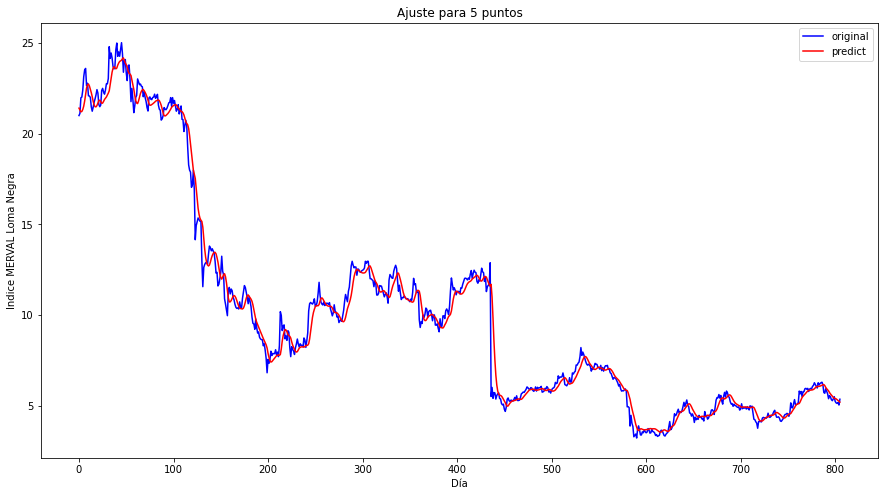

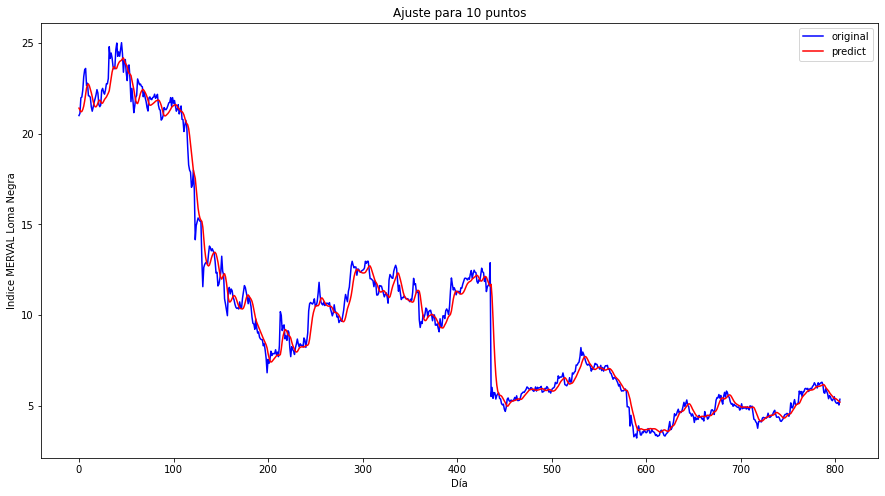

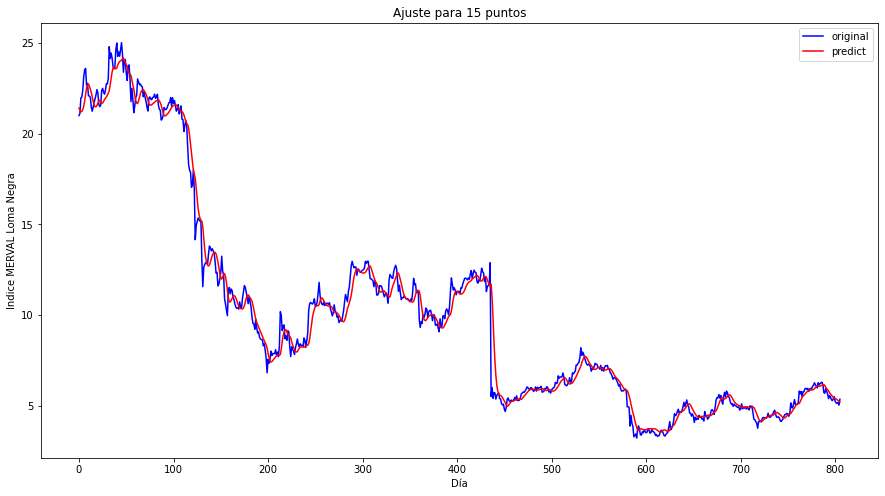

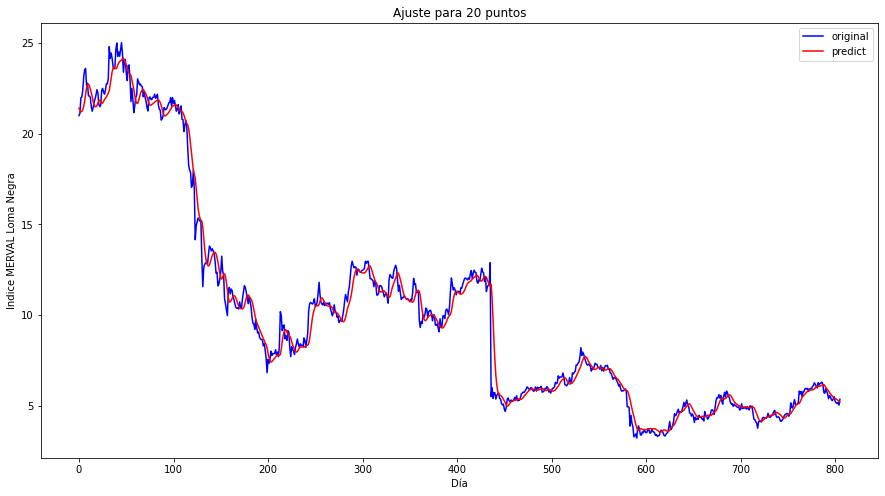

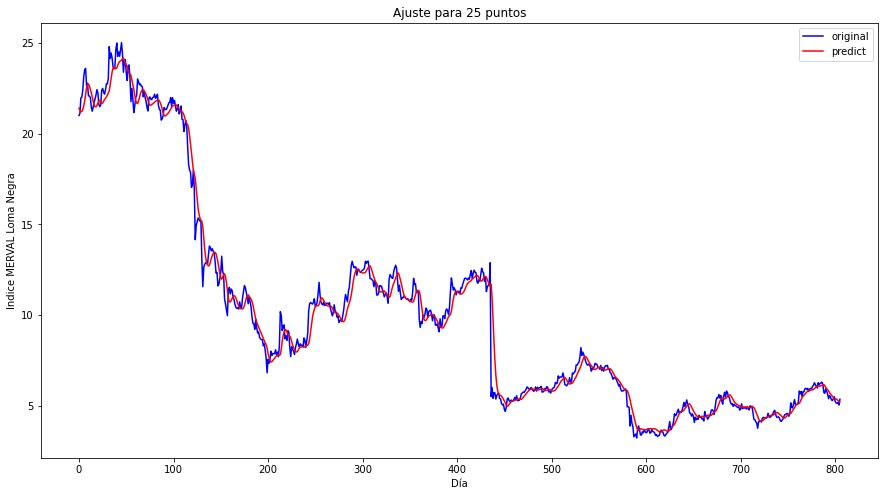

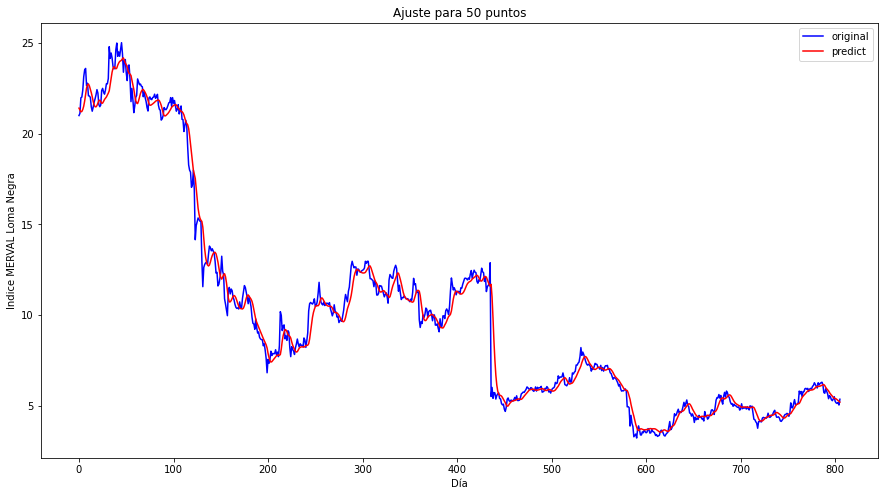

In [86]:
input_dim = 1
num_layers = 2
hidden_dim = 32
output_dim = 1
num_epochs = 50

windows = [2, 5, 10, 15, 20, 25, 50]
fig, ax = plt.subplots(figsize=(15,8))

for w in windows:
    window = w
    x_train, y_train, x_test, y_test = split_data(df_train, df_test, w)
    x_train_lstm = torch.from_numpy(x_train).type(torch.Tensor)
    x_test_lstm = torch.from_numpy(x_test).type(torch.Tensor)
    y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
    y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
    model_reset(model)
    model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
    print(model)
    print('TRAINING FOR {} POINTS'.format(w))

    criterion = torch.nn.MSELoss()
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    y_train_pred_lstm = train_LSTM()
    fig, ax1 = plt.subplots(figsize=(15,8))
    ax1.set_title('Ajuste para {} puntos'.format(w))
    model_adjust()
ax.legend(title="Ventanas", labels=windows)

El valor óptimo de ventana de datos fue de 10 valores para el ajuste en los datos de entrenamiento.

LSTM(
  (lstm): LSTM(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
TRAINING FOR RECURRENT LAYERS = 1
Epoch  0 MSE:  0.5126047134399414
Epoch  1 MSE:  0.5023859739303589
Epoch  2 MSE:  0.49248015880584717
Epoch  3 MSE:  0.4828643798828125
Epoch  4 MSE:  0.4735093414783478
Epoch  5 MSE:  0.4643884599208832
Epoch  6 MSE:  0.4554789960384369
Epoch  7 MSE:  0.44675832986831665
Epoch  8 MSE:  0.43820157647132874
Epoch  9 MSE:  0.42978209257125854
Epoch  10 MSE:  0.4214724898338318
Epoch  11 MSE:  0.4132458567619324
Epoch  12 MSE:  0.4050772190093994
Epoch  13 MSE:  0.3969433605670929
Epoch  14 MSE:  0.388822466135025
Epoch  15 MSE:  0.3806934952735901
Epoch  16 MSE:  0.37253537774086
Epoch  17 MSE:  0.3643271327018738
Epoch  18 MSE:  0.3560466766357422
Epoch  19 MSE:  0.3476715385913849
Epoch  20 MSE:  0.3391781747341156
Epoch  21 MSE:  0.3305419683456421
Epoch  22 MSE:  0.3217369019985199
Epoch  23 MSE:  0.3127356469631195
Epoch  24 MSE:  0.30350893735

Epoch  7 MSE:  0.43814441561698914
Epoch  8 MSE:  0.4203202724456787
Epoch  9 MSE:  0.4020203649997711
Epoch  10 MSE:  0.38306015729904175
Epoch  11 MSE:  0.3632669746875763
Epoch  12 MSE:  0.3425188958644867
Epoch  13 MSE:  0.3208221197128296
Epoch  14 MSE:  0.2984413206577301
Epoch  15 MSE:  0.2761121392250061
Epoch  16 MSE:  0.2553592324256897
Epoch  17 MSE:  0.23884925246238708
Epoch  18 MSE:  0.23041096329689026
Epoch  19 MSE:  0.23339347541332245
Epoch  20 MSE:  0.24459324777126312
Epoch  21 MSE:  0.25363677740097046
Epoch  22 MSE:  0.25599372386932373
Epoch  23 MSE:  0.25286200642585754
Epoch  24 MSE:  0.24692746996879578
Epoch  25 MSE:  0.24058617651462555
Epoch  26 MSE:  0.2353832721710205
Epoch  27 MSE:  0.23197060823440552
Epoch  28 MSE:  0.23032763600349426
Epoch  29 MSE:  0.23006534576416016
Epoch  30 MSE:  0.23068030178546906
Epoch  31 MSE:  0.23171009123325348
Epoch  32 MSE:  0.23279990255832672
Epoch  33 MSE:  0.23371413350105286
Epoch  34 MSE:  0.23432175815105438
Epoc

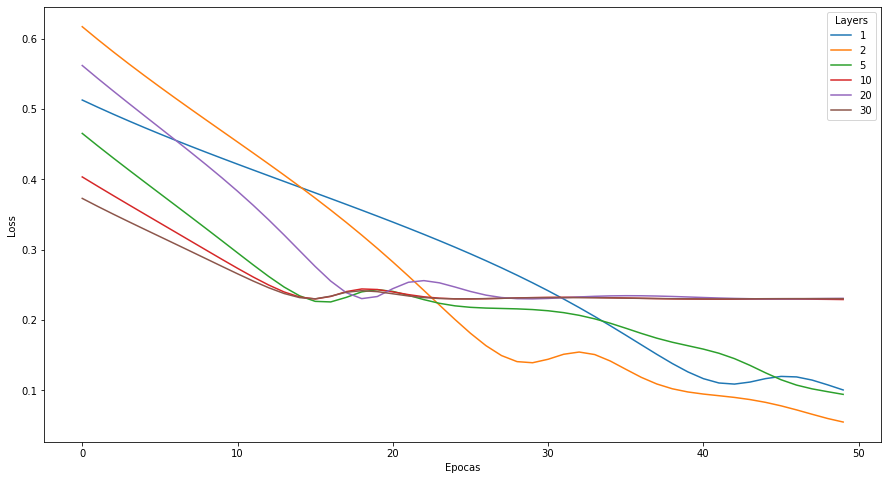

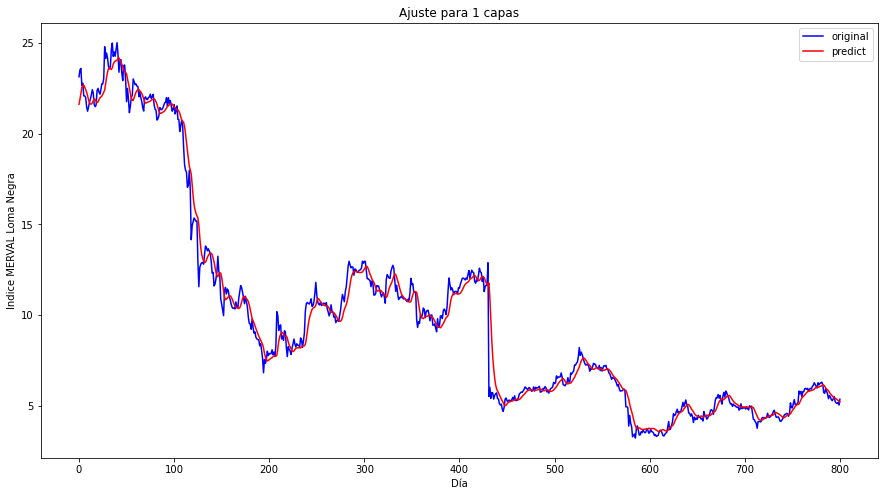

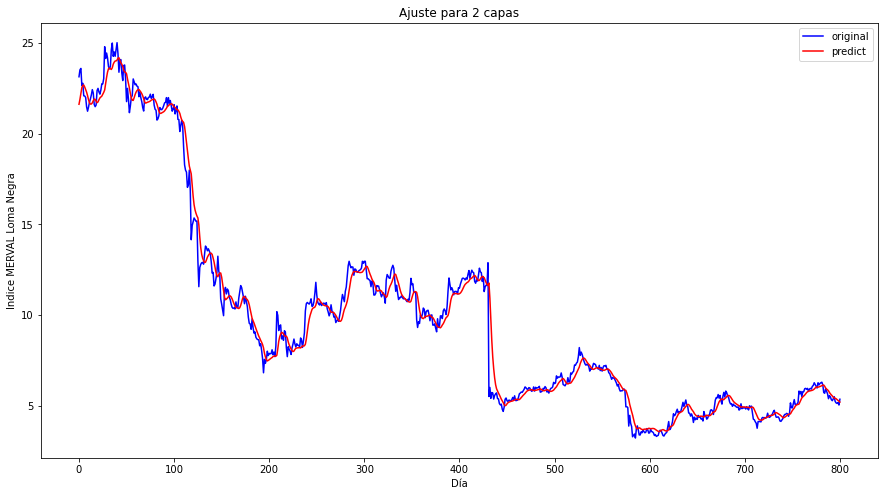

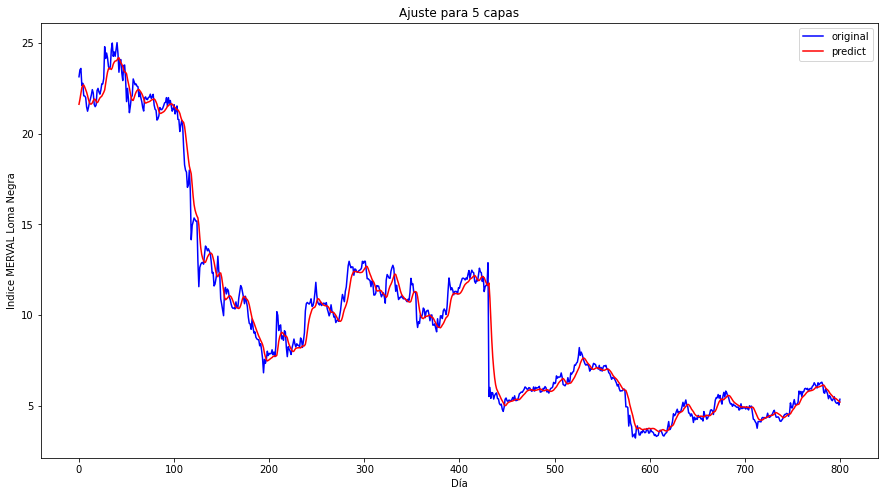

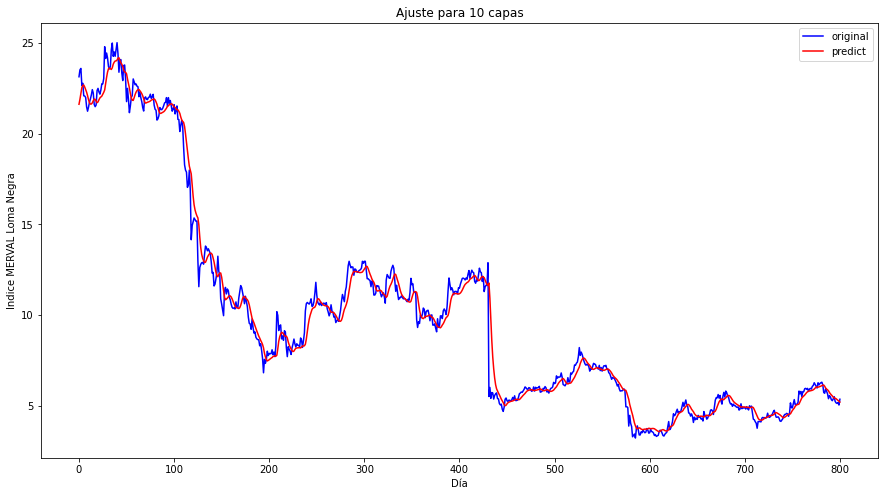

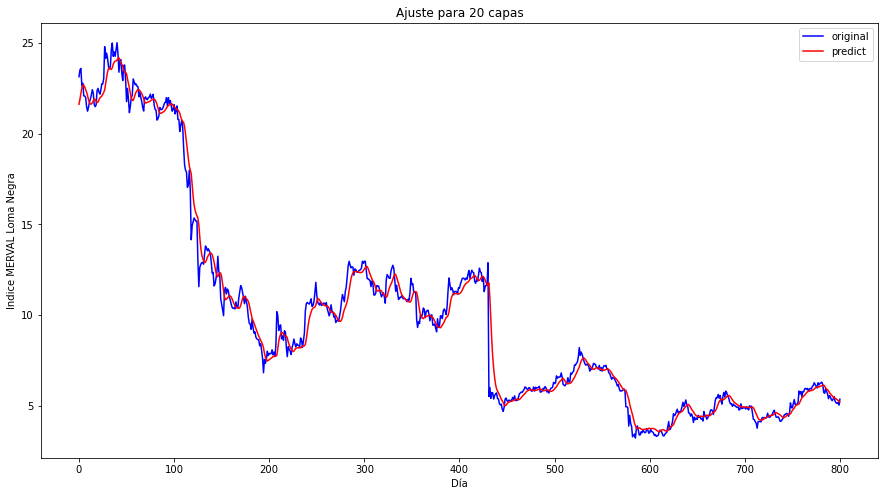

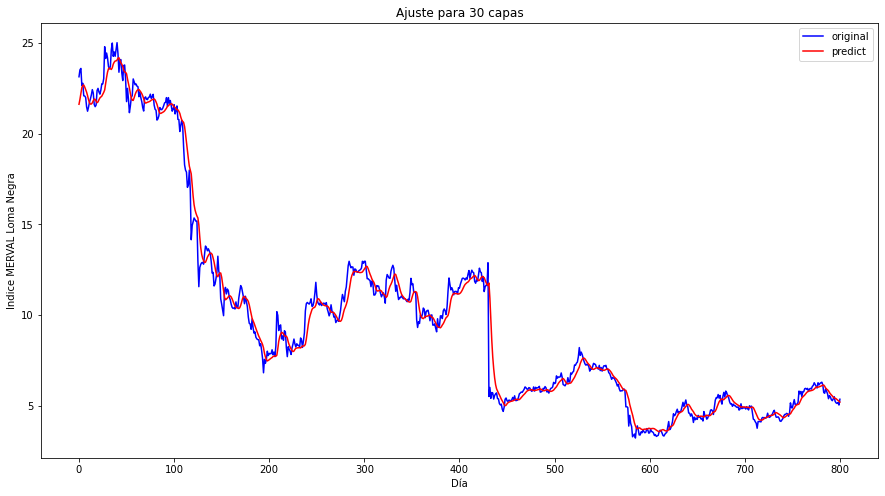

In [38]:
input_dim = 1
hidden_dim = 32
output_dim = 1
num_epochs = 50
window = 5

n_layers = [1, 2, 5, 10, 20, 30]
fig, ax = plt.subplots(figsize=(15,8))

for layer in n_layers:
    layer_dim = layer
    model_reset(model)
    model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=layer_dim)
    print(model)
    print('TRAINING FOR RECURRENT LAYERS = {}'.format(layer))


    criterion = torch.nn.MSELoss()
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    y_train_pred_lstm = train_LSTM()
    fig, ax1 = plt.subplots(figsize=(15,8))
    ax1.set_title('Ajuste para {} capas'.format(layer))
    model_adjust()
ax.legend(title="Layers", labels=n_layers)

También para la LSTM se obtuvo el mejor ajuste para 2 capas internas de la red.

Se define entonces el modelo óptimo en base a lo analizado previamente. Se entrena y se grafica la predicción junto con los valores originales.

In [87]:
input_dim = 1
num_layers = 2
hidden_dim = 256
output_dim = 1
num_epochs = 200
window = 10

x_train, y_train, x_test, y_test = split_data(df_train, df_test, window)
x_train_lstm = torch.from_numpy(x_train).type(torch.Tensor)
x_test_lstm = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model_reset(model)
print(model)
criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.0001)

LSTM(
  (lstm): LSTM(1, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


Epoch  0 MSE:  0.46492379903793335
Epoch  1 MSE:  0.4579610526561737
Epoch  2 MSE:  0.45109617710113525
Epoch  3 MSE:  0.4443153142929077
Epoch  4 MSE:  0.43760761618614197
Epoch  5 MSE:  0.4309631884098053
Epoch  6 MSE:  0.42437171936035156
Epoch  7 MSE:  0.4178224503993988
Epoch  8 MSE:  0.41130417585372925
Epoch  9 MSE:  0.40480512380599976
Epoch  10 MSE:  0.39831262826919556
Epoch  11 MSE:  0.3918137550354004
Epoch  12 MSE:  0.3852956295013428
Epoch  13 MSE:  0.37874549627304077
Epoch  14 MSE:  0.37215083837509155
Epoch  15 MSE:  0.3654997944831848
Epoch  16 MSE:  0.3587808907032013
Epoch  17 MSE:  0.35198330879211426
Epoch  18 MSE:  0.3450969457626343
Epoch  19 MSE:  0.33811265230178833
Epoch  20 MSE:  0.3310225307941437
Epoch  21 MSE:  0.32381993532180786
Epoch  22 MSE:  0.316500186920166
Epoch  23 MSE:  0.3090607225894928
Epoch  24 MSE:  0.30150172114372253
Epoch  25 MSE:  0.29382696747779846
Epoch  26 MSE:  0.28604456782341003
Epoch  27 MSE:  0.2781679928302765
Epoch  28 MSE:  

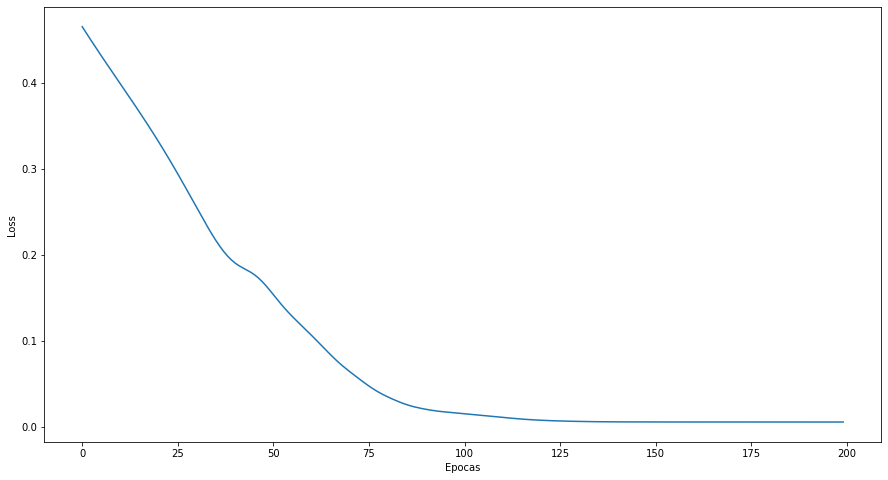

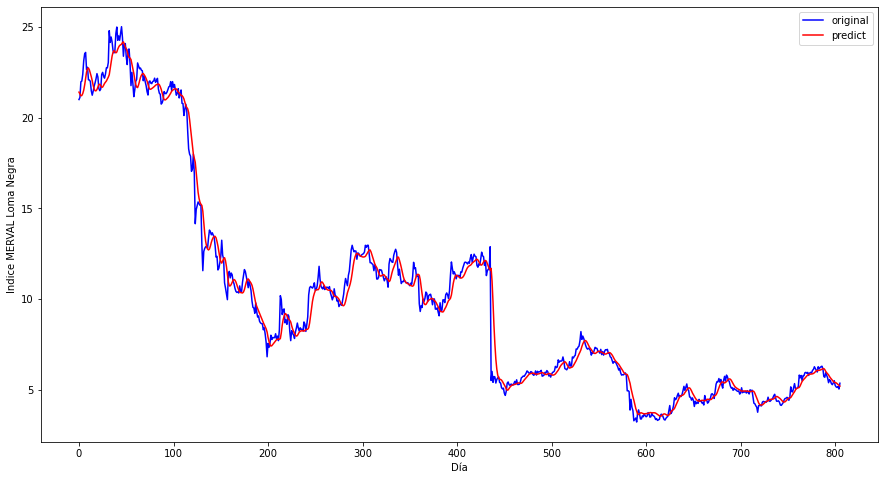

In [88]:
fig, ax = plt.subplots(figsize=(15,8))
y_train_pred_lstm = train_LSTM()
fig, ax1 = plt.subplots(figsize=(15,8))
model_adjust()

In [89]:
y_test_pred_lstm = model(x_test_lstm)
y_test_pred_lstm

tensor([[-0.7912],
        [-0.7839],
        [-0.7782],
        [-0.7706],
        [-0.7623],
        [-0.7541],
        [-0.7477],
        [-0.7427],
        [-0.7399],
        [-0.7407],
        [-0.7427],
        [-0.7462],
        [-0.7515],
        [-0.7572],
        [-0.7646],
        [-0.7722],
        [-0.7806],
        [-0.7892],
        [-0.7907],
        [-0.7899],
        [-0.7891],
        [-0.7865],
        [-0.7820],
        [-0.7750],
        [-0.7662],
        [-0.7592],
        [-0.7522],
        [-0.7491],
        [-0.7503],
        [-0.7500],
        [-0.7498],
        [-0.7484],
        [-0.7461],
        [-0.7423],
        [-0.7376],
        [-0.7320],
        [-0.7266],
        [-0.7195],
        [-0.7146],
        [-0.7126],
        [-0.7122],
        [-0.7143],
        [-0.7171],
        [-0.7206],
        [-0.7264],
        [-0.7325],
        [-0.7407],
        [-0.7458],
        [-0.7495],
        [-0.7522],
        [-0.7533],
        [-0.7534],
        [-0.

In [90]:
predict_test_LSTM = pd.DataFrame(scaler.inverse_transform(y_test_pred_lstm.detach().numpy()))
predict_test_LSTM

,0
0,5.487282
1,5.566607
2,5.628478
3,5.711437
4,5.801828
...,...
190,6.920896
191,6.957323
192,6.969442
193,6.947075


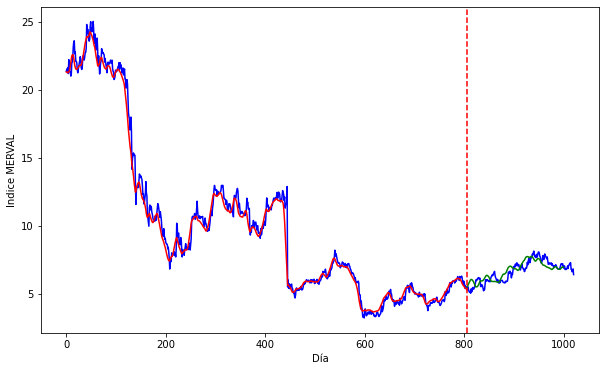

In [91]:
predict_LSTM = pd.DataFrame(scaler.inverse_transform(y_train_pred_lstm.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

fig, ax = plt.subplots(figsize=(10, 6))

# plt.plot(original.index, original[0], c='b')

plt.plot(data_ln.Close, c='b')
plt.plot(predict_LSTM.index, predict_LSTM[0], c='r')
plt.plot(np.arange(predict_LSTM.index.max() + 1, predict_LSTM.index.max() + 1 + len(predict_test_LSTM)), predict_test_LSTM[0], c='g')
plt.xlabel('Día')
plt.ylabel('Indice MERVAL');
plt.axvline(x=predict_LSTM.index.max() + 1, c='r', linestyle='--'); # a donde arranca la prediccion

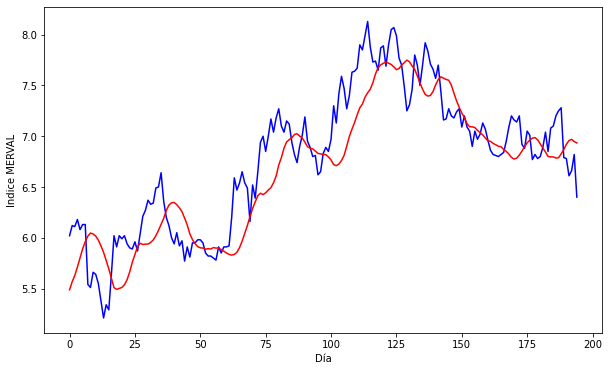

In [92]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.plot(data_ln.loc[len(data_ln)-len(predict_test_LSTM):len(data_ln), 'Close'].reset_index(drop=True), c='b')
plt.plot(predict_test_LSTM.index, predict_test_LSTM[0], c='r')
plt.xlabel('Día')
plt.ylabel('Indice MERVAL');

Para comparar ambos modelos, se pueden utilizar como métricas el error absoluto medio y el error cuadrático medio, comparando así el desvío de cada uno de ellos de los valores del set de testeo.

In [93]:
predictionsRNN = y_test_pred.detach().numpy()
predictionsLSTM = y_test_pred_lstm.detach().numpy()

mae_rnn = mean_absolute_error(y_test_rnn, predictionsRNN)
mae_lstm = mean_absolute_error(y_test_lstm, predictionsLSTM)
mse_rnn = mean_squared_error(y_test_rnn, predictionsRNN)
mse_lstm = mean_squared_error(y_test_lstm, predictionsLSTM)
print('MAE comparison: RNN = {} LSTM = {}'.format(mae_rnn, mae_lstm))
print('MSE comparison: RNN = {} LSTM = {}'.format(mse_rnn, mse_lstm))




MAE comparison: RNN = 0.018268996849656105 LSTM = 0.02284361608326435
MSE comparison: RNN = 0.0005170870572328568 LSTM = 0.0008022105321288109


Con los parámetros fijados, la RNN obtuvo un mejor desempeño que la LSTM.

# Ejercicio 2

Se importan las bibliotecas para la descarga de los datos de Meli, el etiquetado y el preprocesamiento del texto con snorkel y torchtext.

In [1]:
import http.client
from urllib.parse import quote_plus
import json
from config import AppCfg
import dask.dataframe as dd
from preprocessing import dask_proc
import re
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchtext.legacy.data import LabelField, Field, TabularDataset, BucketIterator
from torchtext.data.utils import get_tokenizer

In [3]:
conn = http.client.HTTPSConnection("api.mercadolibre.com")

Se genera el dataset de cuatro clases a partir de dos categorías de productos: "Computación" y "Celulares"

In [4]:
conn.request("GET", "/sites/MLA/categories")
res = conn.getresponse()
data = res.read()
print(data.decode("utf-8"))

[{"id":"MLA5725","name":"Accesorios para Vehículos"},{"id":"MLA1512","name":"Agro"},{"id":"MLA1403","name":"Alimentos y Bebidas"},{"id":"MLA1071","name":"Animales y Mascotas"},{"id":"MLA1367","name":"Antigüedades y Colecciones"},{"id":"MLA1368","name":"Arte, Librería y Mercería"},{"id":"MLA1743","name":"Autos, Motos y Otros"},{"id":"MLA1384","name":"Bebés"},{"id":"MLA1246","name":"Belleza y Cuidado Personal"},{"id":"MLA1039","name":"Cámaras y Accesorios"},{"id":"MLA1051","name":"Celulares y Teléfonos"},{"id":"MLA1648","name":"Computación"},{"id":"MLA1144","name":"Consolas y Videojuegos"},{"id":"MLA1500","name":"Construcción"},{"id":"MLA1276","name":"Deportes y Fitness"},{"id":"MLA5726","name":"Electrodomésticos y Aires Ac."},{"id":"MLA1000","name":"Electrónica, Audio y Video"},{"id":"MLA2547","name":"Entradas para Eventos"},{"id":"MLA407134","name":"Herramientas"},{"id":"MLA1574","name":"Hogar, Muebles y Jardín"},{"id":"MLA1499","name":"Industrias y Oficinas"},{"id":"MLA1459","name":"I

In [5]:
pd.DataFrame(json.loads(data.decode("utf-8")))

,id,name
0,MLA5725,Accesorios para Vehículos
1,MLA1512,Agro
2,MLA1403,Alimentos y Bebidas
3,MLA1071,Animales y Mascotas
4,MLA1367,Antigüedades y Colecciones
5,MLA1368,"Arte, Librería y Mercería"
6,MLA1743,"Autos, Motos y Otros"
7,MLA1384,Bebés
8,MLA1246,Belleza y Cuidado Personal
9,MLA1039,Cámaras y Accesorios


In [6]:
cfg = AppCfg()

class MeliGet:
    """
    Clase basica con fines de demostracion de uso.
    No recomendado para fines de obtener performance.
    """
    
    def __init__(self, cfg):
        self.conn = http.client.HTTPSConnection("api.mercadolibre.com")
        self.payload = ''
        self.headers = {
            'Bearer': cfg.ACCESS_TOKEN
        }
        
    def search_by_category(self, category_id, offset):
        try:
            self.conn.request(
                "GET", 
                f"/sites/MLA/search?category={category_id}&offset={offset}", 
                self.payload, 
                self.headers
            )
            res = self.conn.getresponse()
            data = res.read()
            df = pd.DataFrame(json.loads(data.decode("utf-8"))['results'])
        except:
            # print("DataFrame vacio.")
            df = pd.DataFrame([])
        return df
        
    def append_offset(self, category_id, n_offset):
        dfs = [self.search_by_category(category_id, offset) for offset in range(1, n_offset+1)]
        dfs = pd.concat(dfs).reset_index(drop=True)
        return dfs
    
    def build_dataset(self, category_list, n_offset):
        dfs = [self.append_offset(category_id, n_offset) for category_id in category_list]
        dfs = pd.concat(dfs).reset_index(drop=True)
        return dfs
        

In [7]:
meli = MeliGet(cfg)

In [8]:
tmp_df1 = meli.search_by_category('MLA1648', 1)
tmp_df2 = meli.search_by_category('MLA1051', 1)

In [9]:
tmp_df1.head(2)

,id,site_id,title,seller,price,prices,sale_price,currency_id,available_quantity,sold_quantity,...,domain_id,catalog_product_id,tags,order_backend,use_thumbnail_id,offer_score,offer_share,match_score,winner_item_id,catalog_listing
0,MLA879774146,MLA,Computadora Completa Amd Intel Dual Core 8gb L...,"{'id': 1534239, 'permalink': 'http://perfil.me...",63999.0,"{'id': 'MLA879774146', 'prices': [{'id': '33',...",None,ARS,150,250,...,MLA-DESKTOP_COMPUTERS,None,"[loyalty_discount_eligible, ahora-12, brand_ve...",1,True,None,None,None,None,NaN
1,MLA924403881,MLA,Mouse De Juego Logitech G Series Lightsync G2...,"{'id': 1534239, 'permalink': 'http://perfil.me...",2399.0,"{'id': 'MLA924403881', 'prices': [{'id': '37',...",None,ARS,130,2357,...,MLA-COMPUTER_MICE,MLA16211422,"[good_quality_thumbnail, loyalty_discount_elig...",2,True,None,None,None,None,True


In [10]:
tmp_df2.head(2)

,id,site_id,title,seller,price,prices,sale_price,currency_id,available_quantity,sold_quantity,...,domain_id,catalog_product_id,tags,catalog_listing,use_thumbnail_id,offer_score,offer_share,match_score,winner_item_id,order_backend
0,MLA919905820,MLA,LG K41s 32 Gb Titanio 3 Gb Ram,"{'id': 287440338, 'permalink': 'http://perfil....",24999.0,"{'id': 'MLA919905820', 'prices': [{'id': '65',...",None,ARS,20,2023,...,MLA-CELLPHONES,MLA15808236,"[extended_warranty_eligible, good_quality_pict...",True,True,None,None,None,None,1
1,MLA1103220222,MLA,Moto G20 64 Gb Azul Cielo 4 Gb Ram,"{'id': 608846165, 'permalink': 'http://perfil....",29999.0,"{'id': 'MLA1103220222', 'prices': [{'id': '3',...",None,ARS,1483,13652,...,MLA-CELLPHONES,MLA18176776,"[extended_warranty_eligible, good_quality_pict...",True,True,None,None,None,None,2


In [11]:
tmp_df1.columns

Index(['id', 'site_id', 'title', 'seller', 'price', 'prices', 'sale_price',
       'currency_id', 'available_quantity', 'sold_quantity', 'buying_mode',
       'listing_type_id', 'stop_time', 'condition', 'permalink', 'thumbnail',
       'thumbnail_id', 'accepts_mercadopago', 'installments', 'address',
       'shipping', 'seller_address', 'attributes', 'differential_pricing',
       'original_price', 'category_id', 'official_store_id', 'domain_id',
       'catalog_product_id', 'tags', 'order_backend', 'use_thumbnail_id',
       'offer_score', 'offer_share', 'match_score', 'winner_item_id',
       'catalog_listing'],
      dtype='object')

In [12]:
df = meli.build_dataset(['MLA1648','MLA1051'], 300)

In [13]:
df.shape

(30000, 37)

In [14]:
df = df[['id', 'site_id', 'title', 'category_id', 'domain_id']]

In [15]:
df.to_csv('items_meli.csv', sep="␗", index=False)

Se preprocesa la información

In [4]:
df = pd.read_csv('items_meli.csv', sep="␗", engine='python')

In [5]:
df.head(3)

,id,site_id,title,category_id,domain_id
0,MLA879774146,MLA,Computadora Completa Amd Intel Dual Core 8gb L...,MLA1649,MLA-DESKTOP_COMPUTERS
1,MLA924403881,MLA,Mouse De Juego Logitech G Series Lightsync G2...,MLA1714,MLA-COMPUTER_MICE
2,MLA930630420,MLA,Notebook Lenovo Ideapad 15iml05 Abyss Blue Tá...,MLA1652,MLA-NOTEBOOKS


In [6]:
tmp = dd.from_pandas(df, npartitions=5)

# Nombre de columna a preprocesar
title = 'title'

tmp = tmp.assign(title=tmp.map_partitions(dask_proc, title, meta='str')).compute(scheduler='processes')
tmp.title = tmp.title.astype('U')

In [7]:
df = tmp.copy()
del tmp

Se cuentan las entradas disponibles para cada id única y en base a eso se eligen las cuatro clases. Se opta por cuatro alternativas similares que pongan a prueba el modelo: celulares, notebooks, pcs de escritorio y discos rígidos.

In [8]:
df.domain_id.value_counts()

MLA-CELLPHONES                           13835
MLA-NOTEBOOKS                             4520
MLA-DESKTOP_COMPUTERS                     3123
MLA-TONERS                                 671
MLA-INK_CARTRIDGES                         648
MLA-ROUTERS_AND_WIRELESS_SYSTEMS           560
MLA-HARD_DRIVES_AND_SSDS                   478
MLA-COMPUTER_MICE                          439
MLA-SMARTWATCHES                           425
MLA-PC_KEYBOARDS                           378
MLA-PRINTER_INKS                           356
MLA-STABILIZERS_AND_UPS                    353
MLA-DATA_CABLES_AND_ADAPTERS               298
MLA-COMPUTER_MONITORS                      291
MLA-PRINTERS                               261
MLA-PENDRIVES                              255
MLA-HEADPHONES                             216
MLA-DESKTOP_COMPUTER_POWER_SUPPLIES        206
MLA-3D_PRINTER_FILAMENTS                   205
MLA-KEYBOARD_AND_MOUSE_KITS                203
MLA-LAPTOP_STANDS                          174
MLA-RAM_MEMOR

In [9]:
df.to_csv('items_meli_proc.csv', sep="␗", index=False)

Una vez creado el dataset, se definen los valores de etiqueta para cada clase.

In [10]:
df = pd.read_csv('items_meli_proc.csv', sep="␗", engine='python')

In [11]:
df = df[df.domain_id.isin(['MLA-DESKTOP_COMPUTERS', 'MLA-NOTEBOOKS', 'MLA-CELLPHONES', 'MLA-HARD_DRIVES_AND_SSDS'])].reset_index(drop=True)

In [12]:
df = df[['title', 'domain_id']]

In [13]:
df = df[df.domain_id.isin(['MLA-DESKTOP_COMPUTERS', 'MLA-NOTEBOOKS', 'MLA-CELLPHONES', 'MLA-HARD_DRIVES_AND_SSDS'])].reset_index(drop=True)

<AxesSubplot:>

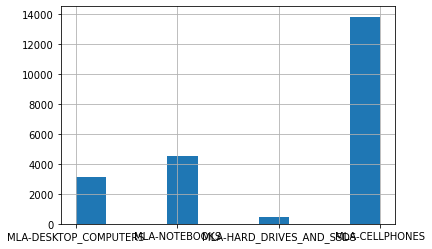

In [14]:
df.domain_id.hist()

In [15]:
df['domain_id'].value_counts()

MLA-CELLPHONES              13835
MLA-NOTEBOOKS                4520
MLA-DESKTOP_COMPUTERS        3123
MLA-HARD_DRIVES_AND_SSDS      478
Name: domain_id, dtype: int64

In [16]:
df["domain_id"].replace({"MLA-DESKTOP_COMPUTERS": 0, "MLA-NOTEBOOKS": 1, "MLA-CELLPHONES": 2, "MLA-HARD_DRIVES_AND_SSDS": 3}, inplace=True)

In [17]:
df.domain_id.unique()

array([0, 1, 3, 2], dtype=int64)

Como las clases están muy desbalanceadas en cantidad de entradas, se opta por restringir el número de muestras al de la clase con menor cantidad (discos)

In [18]:
sample0 = df[df['domain_id']==0].sample(n=478)
sample1 = df[df['domain_id']==1].sample(n=478)
sample2 = df[df['domain_id']==2].sample(n=478)
sample3 = df[df['domain_id']==3].sample(n=478)

df = pd.concat([sample0,sample1,sample2, sample3])

<AxesSubplot:>

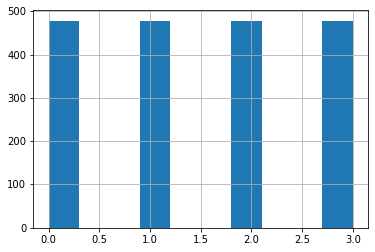

In [19]:
df.domain_id.hist()

A continuación, se crean los sets de entrenamiento, validación y testeo a partir de set acotado. Para ello, se parte primero la información según clase y después se divide en los tres sets, de forma tal de que la cantidad de muestras sea la misma en cada caso.

In [20]:
df_0 = df[df['domain_id']==0]
df_1 = df[df['domain_id']==1]
df_2 = df[df['domain_id']==2]
df_3 = df[df['domain_id']==3]



df_0_train, df_0_test = train_test_split(df_0)
df_1_train, df_1_test = train_test_split(df_1)
df_2_train, df_2_test = train_test_split(df_2)
df_3_train, df_3_test = train_test_split(df_3)



df_0_train, df_0_valid = train_test_split(df_0_train)
df_1_train, df_1_valid = train_test_split(df_1_train)
df_2_train, df_2_valid = train_test_split(df_2_train)
df_3_train, df_3_valid = train_test_split(df_3_train)


df_train = pd.concat([df_0_train, df_1_train])
df_valid = pd.concat([df_0_valid, df_1_valid])
df_test = pd.concat([df_0_test, df_1_test])

df_train2 = pd.concat([df_0_train, df_1_train, df_2_train, df_3_train])
df_valid2 = pd.concat([df_0_valid, df_1_valid, df_2_valid, df_3_valid])
df_test2 = pd.concat([df_0_test, df_1_test, df_2_test, df_3_test])

df_train.to_csv('train1.csv', index=False)
df_valid.to_csv('valid1.csv', index=False)
df_test.to_csv('test1.csv', index=False)

df_train2.to_csv('train2.csv', index=False)
df_valid2.to_csv('valid2.csv', index=False)
df_test2.to_csv('test2.csv', index=False)

In [21]:
df_test2['domain_id'].value_counts()

0    120
1    120
2    120
3    120
Name: domain_id, dtype: int64

Luego, se generan los tokens y el vocabulario con spacy y se crean los iteradores de pytorch para cargar los sets de entrenamiento, testeo y validación al modelo

In [22]:
tokenizer = get_tokenizer('spacy', language='es_core_news_sm')

In [23]:
TEXT = Field(tokenize=tokenizer, lower=True, batch_first=True, include_lengths=True)
LABEL = LabelField(dtype=torch.float, batch_first=True, sequential=False)
fields = [('title', TEXT), ('domain_id', LABEL)]

In [24]:
train, valid, test = TabularDataset.splits(path=r'C:\Users\amest\Downloads\Git\modulo-2-rnn\rnn', train='train1.csv', validation='valid1.csv', test='test1.csv',
                                           format='CSV', fields=fields, skip_header=True)

for example in train.examples:
    print(example.title, example.domain_id)

['pc', 'computadora', 'completa', 'intel', 'i3', '1', 'tb', '4', 'gb', 'con', 'monitor', 'led', '19'] 0
['pc', 'armada', 'gamer', 'amd', 'a8', '9600', 'x10', 'video', 'r7', '8', 'gb', 'ram', 'hdmi', 'w10', '64'] 0
['pc', 'armada', 'oficina', 'intel', 'i3', '9100', '8', 'gb', 'ssd', '240', 'gb', 'wifi', 'c3'] 0
['pc', 'gamer', 'armada', 'cpu', 'intel', 'core', 'i7', '8700', 'ddr4', '1', 'tb', 'hdmi', 'vga'] 0
['pc', 'armada', 'intel', 'core', 'i5', '1', 'tb', '8', 'gb', 'ram', 'graficos', 'hd', 'nuevas', 'soft'] 0
['pc', 'de', 'escritorio', 'kit', 'iqual', 'intel', 'core', 'i3', '9100', '8', 'gb', 'ddr4', '1', 'tb'] 0
['pc', 'gamer', 'amd', 'athlon', '3000', 'vega3', '240', 'gb', '8', 'gb', 'fortnite', 'y', 'mas', 'p1'] 0
['computadora', 'completa', 'amd', 'intel', 'dual', 'core', '8', 'gb', 'led', '22', 'lol'] 0
['pc', 'armada', 'intel', 'core', 'i7', '1', 'tb', '16', 'gb', 'de', 'ram', 'graficos', 'hd', 'nuevas'] 0
['pc', 'armada', 'gamer', 'video', 'cpu', 'amd', 'vega', 'ddr4', 'fort

In [25]:
TEXT.build_vocab(train, min_freq=3)
LABEL.build_vocab(train)
print(list(TEXT.vocab.stoi.items()))
print(list(LABEL.vocab.stoi.items()))

[('<unk>', 0), ('<pad>', 1), ('gb', 2), ('intel', 3), ('8', 4), ('notebook', 5), ('pc', 6), ('ssd', 7), ('core', 8), ('ram', 9), (' ', 10), ('armada', 11), ('  ', 12), ('1', 13), ('4', 14), ('tb', 15), ('10', 16), ('amd', 17), ('de', 18), ('windows', 19), ('15', 20), ('i3', 21), ('6', 22), ('14', 23), ('gamer', 24), ('256', 25), ('hd', 26), ('home', 27), ('i5', 28), ('g', 29), ('hp', 30), ('graphics', 31), ('240', 32), ('ryzen', 33), ('1366x768px', 34), ('uhd', 35), ('w10', 36), ('16', 37), ('dual', 38), ('computadora', 39), ('cpu', 40), ('5', 41), ('completa', 42), ('celeron', 43), ('kit', 44), ('ddr4', 45), ('vega', 46), ('1920x1080px', 47), ('i7', 48), ('128', 49), ('n4020', 50), ('lenovo', 51), ('500', 52), ('g7', 53), ('hdd', 54), ('480', 55), ('radeon', 56), ('asus', 57), ('dell', 58), ('64', 59), ('soft', 60), ('win10', 61), ('120', 62), ('11', 63), ('fhd', 64), ('escritorio', 65), ('graficos', 66), ('nuevas', 67), ('1005g1', 68), ('nueva', 69), ('wifi', 70), ('hdmi', 71), ('led

In [26]:
train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.title),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.title),
                            device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.title),
                            device=device, sort=True, sort_within_batch=True)

In [27]:
for batch_no, batch in enumerate(train_iter):
    text, batch_len = batch.title
    print(text, batch_len)
    print(batch.domain_id)

tensor([[ 39,  42,  17,   3,  38,   8,   4,   2,  72, 107, 109],
        [  6,  39,  17,  80, 208,  42,  85,  79,  72, 107,  69],
        [ 39,  42,  17,   3,  38,   8,   4,   2,  72, 237, 109],
        [ 39,  42,  17,   3,  38,   8,   4,   2,  72, 237, 109],
        [  6,  39,  17,  80, 208,  42,  85,  79,  72, 107,  69],
        [ 39,  42,  17,   3,  38,   8,   4,   2,  72, 107, 109],
        [ 39,  42,  17,   3,  38,   8,   4,   2,  72, 237, 109],
        [  6,  39,  17,  80, 208,  42,  85,  79,  72, 107,  69],
        [  6,  39,  17,  80, 208,  42,  85,  79,  72, 107,  69],
        [ 39,  42,  17,   3,  38,   8,   4,   2,  72, 107, 109],
        [ 39,  42,  17,   3,  38,   8,   4,   2,  72, 237, 109],
        [  6,  11,   3,   8,  28,   4,   2,  97,  36, 113,   1],
        [  6,  11,   3,   8,  28,   4,   2,  97,  36, 113,   1],
        [  6,  11,   3,   8,  28,   4,   2,  97,  36, 113,   1],
        [ 39,  42,  17,   3,  38,   8,  79,  72, 107, 109,   1],
        [  6,  11,   3,  

Se define una LSTM para el procesamiento de los datos de texto, con una sola capa, a la que se le permite modificarle el número de dimensiones ocultas

In [28]:

class LSTM(nn.Module):

    def __init__(self, dimension):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(TEXT.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*dimension, 1)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out


Se definen funciones checkpoint para salvar los parámetros del modelo durante el momento óptimo del entrenamiento (que podría no ser la última época)

In [29]:

# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

Primero, se define la función de entrenamiento para el caso de clasificación binaria, con binary cross-entropy loss como función de pérdida y validación. Se entrena el modelo para 16 estados ocultos y 10 épocas.

In [30]:

# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = r'C:\Users\amest\Downloads\Git\modulo-2-rnn\rnn',
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for batch_no, batch in enumerate(train_loader):
            title, title_len = batch.title
            labels = batch.domain_id
            labels = labels.to(device)
            title = title.to(device)
            title_len = title_len.to(device)
            output = model(title, title_len)

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for batch_no, batch in enumerate(valid_loader):
                    title, title_len = batch.title
                    labels = batch.domain_id
                    labels = labels.to(device)
                    title = title.to(device)
                    title_len = title_len.to(device)
                    output = model(title, title_len)

                    loss = criterion(output, labels)
                    valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')


model = LSTM(16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train(model=model, optimizer=optimizer, num_epochs=10)

Epoch [1/10], Step [8/170], Train Loss: 0.6332, Valid Loss: 0.5790
Model saved to ==> C:\Users\amest\Downloads\Git\modulo-2-rnn\rnn/model.pt
Model saved to ==> C:\Users\amest\Downloads\Git\modulo-2-rnn\rnn/metrics.pt
Epoch [1/10], Step [16/170], Train Loss: 0.5802, Valid Loss: 0.4867
Model saved to ==> C:\Users\amest\Downloads\Git\modulo-2-rnn\rnn/model.pt
Model saved to ==> C:\Users\amest\Downloads\Git\modulo-2-rnn\rnn/metrics.pt
Epoch [2/10], Step [24/170], Train Loss: 0.4471, Valid Loss: 0.4045
Model saved to ==> C:\Users\amest\Downloads\Git\modulo-2-rnn\rnn/model.pt
Model saved to ==> C:\Users\amest\Downloads\Git\modulo-2-rnn\rnn/metrics.pt
Epoch [2/10], Step [32/170], Train Loss: 0.4215, Valid Loss: 0.3513
Model saved to ==> C:\Users\amest\Downloads\Git\modulo-2-rnn\rnn/model.pt
Model saved to ==> C:\Users\amest\Downloads\Git\modulo-2-rnn\rnn/metrics.pt
Epoch [3/10], Step [40/170], Train Loss: 0.3372, Valid Loss: 0.3056
Model saved to ==> C:\Users\amest\Downloads\Git\modulo-2-rnn\

Se grafica la evolución del error de entrenamiento y de validación durante el proceso. Se observa que el error de validación es menor, lo que puede deberse a que el entrenamiento aplica regularización por dropout, que no corre durante la validación, y esto resulta en una mejor generalización del modelo

Model loaded from <== C:\Users\amest\Downloads\Git\modulo-2-rnn\rnn/metrics.pt


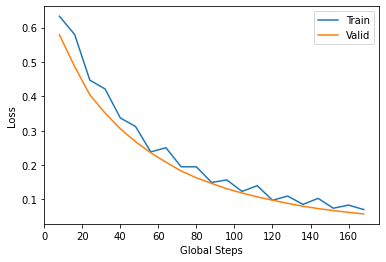

In [31]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(r'C:\Users\amest\Downloads\Git\modulo-2-rnn\rnn' + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

Se define la función de evaluación del modelo sobre el set de testeo, utilizando los parámetros óptimos almacenados en el checkpoint. La función devuelve además la matriz de confusión y el reporte, que permite evaluar las métricas de clasificación obtenidas, como la precisión, el recall y el valor de f1, que son las más adecuadas para valorar este tipo de problemas

Model loaded from <== C:\Users\amest\Downloads\Git\modulo-2-rnn\rnn/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000       120
           0     1.0000    1.0000    1.0000       120

    accuracy                         1.0000       240
   macro avg     1.0000    1.0000    1.0000       240
weighted avg     1.0000    1.0000    1.0000       240



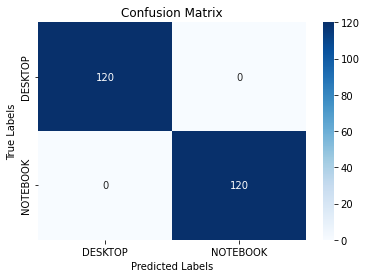

In [32]:
# Evaluation Function

def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for batch_no, batch in enumerate(test_loader):           
            title, title_len = batch.title
            labels = batch.domain_id
            labels = labels.to(device)
            title = title.to(device)
            title_len = title_len.to(device)
            output = model(title, title_len)

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['DESKTOP', 'NOTEBOOK'])
    ax.yaxis.set_ticklabels(['DESKTOP', 'NOTEBOOK'])
    
    
best_model = LSTM(16).to(device)
optimizer = torch.optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(r'C:\Users\amest\Downloads\Git\modulo-2-rnn\rnn' + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

Para el caso binario, el modelo así definido logró una clasificación perfecta del set de testeo

## **Caso multiclase**

Para esta evalaución, se utilizan los datasets de entrenamiento, validación y testeo creados con las cuatro clases seleccionadas en lugar de las dos evaluadas en el ítem anterior. Se repite el proceso de tokenización y creación de vocabulario, además de los iteradores para cada set

In [40]:
TEXT = Field(tokenize=tokenizer, lower=True, batch_first=True, include_lengths=True)
LABEL = LabelField(dtype=torch.long, batch_first=True, sequential=False)
fields = [('title', TEXT), ('domain_id', LABEL)]

In [41]:
train, valid, test = TabularDataset.splits(path=r'C:\Users\amest\Downloads\Git\modulo-2-rnn\rnn', train='train2.csv', validation='valid2.csv', test='test2.csv',
                                           format='CSV', fields=fields, skip_header=True)

for example in train.examples:
    print(example.title, example.domain_id)

['pc', 'computadora', 'completa', 'intel', 'i3', '1', 'tb', '4', 'gb', 'con', 'monitor', 'led', '19'] 0
['pc', 'armada', 'gamer', 'amd', 'a8', '9600', 'x10', 'video', 'r7', '8', 'gb', 'ram', 'hdmi', 'w10', '64'] 0
['pc', 'armada', 'oficina', 'intel', 'i3', '9100', '8', 'gb', 'ssd', '240', 'gb', 'wifi', 'c3'] 0
['pc', 'gamer', 'armada', 'cpu', 'intel', 'core', 'i7', '8700', 'ddr4', '1', 'tb', 'hdmi', 'vga'] 0
['pc', 'armada', 'intel', 'core', 'i5', '1', 'tb', '8', 'gb', 'ram', 'graficos', 'hd', 'nuevas', 'soft'] 0
['pc', 'de', 'escritorio', 'kit', 'iqual', 'intel', 'core', 'i3', '9100', '8', 'gb', 'ddr4', '1', 'tb'] 0
['pc', 'gamer', 'amd', 'athlon', '3000', 'vega3', '240', 'gb', '8', 'gb', 'fortnite', 'y', 'mas', 'p1'] 0
['computadora', 'completa', 'amd', 'intel', 'dual', 'core', '8', 'gb', 'led', '22', 'lol'] 0
['pc', 'armada', 'intel', 'core', 'i7', '1', 'tb', '16', 'gb', 'de', 'ram', 'graficos', 'hd', 'nuevas'] 0
['pc', 'armada', 'gamer', 'video', 'cpu', 'amd', 'vega', 'ddr4', 'fort

['disco', 'solido', 'interno', 'gigabyte', 'gp', 'gstfs31240gntd', '240', 'gb'] 3
['disco', 'solido', 'interno', 'kingston', 'sa400s37', '480', 'g', '480', 'gb', 'negro'] 3
['disco', 'solido', 'interno', 'kingston', 'sa400s37', '480', 'g', '480', 'gb', 'negro'] 3
['disco', 'duro', 'externo', 'western', 'digital', 'wd', 'elements', 'wdbu6y0040bbk', 'wesn', '4', 'tb', 'negro'] 3
['disco', 'solido', 'interno', 'gigabyte', 'gp', 'gstfs31240gntd', '240', 'gb'] 3
['disco', 'solido', 'interno', 'western', 'digital', 'wd', 'green', 'sn350', 'wds480g2g0c', '480', 'gb'] 3
['disco', 'duro', 'externo', 'western', 'digital', 'wd', 'elements', 'wdbu6y0040bbk', 'wesn', '4', 'tb', 'negro'] 3
['disco', 'solido', 'interno', 'western', 'digital', 'sn550', 'wds100t2b0c', '1', 'tb', 'azul'] 3
['disco', 'duro', 'externo', 'western', 'digital', 'wd', 'elements', 'portable', 'wdbu6y0020bbk', '2', 'tb', 'negro'] 3
['disco', 'duro', 'externo', 'western', 'digital', 'wd', 'elements', 'wdbuzg0010bbk', '1', 'tb', 

In [42]:
TEXT.build_vocab(train, min_freq=3)
LABEL.build_vocab(train)
print(list(TEXT.vocab.stoi.items()))
print(list(LABEL.vocab.stoi.items()))

[('<unk>', 0), ('<pad>', 1), ('gb', 2), ('intel', 3), ('ram', 4), ('1', 5), ('8', 6), ('tb', 7), ('disco', 8), ('4', 9), ('notebook', 10), ('pc', 11), (' ', 12), ('ssd', 13), ('core', 14), ('negro', 15), ('armada', 16), ('  ', 17), ('interno', 18), ('g', 19), ('digital', 20), ('western', 21), ('solido', 22), ('10', 23), ('dual', 24), ('480', 25), ('amd', 26), ('de', 27), ('windows', 28), ('wd', 29), ('6', 30), ('15', 31), ('celular', 32), ('i3', 33), ('duro', 34), ('14', 35), ('256', 36), ('gamer', 37), ('hd', 38), ('sim', 39), ('128', 40), ('home', 41), ('240', 42), ('16', 43), ('i5', 44), ('elements', 45), ('externo', 46), ('2', 47), ('hp', 48), ('32', 49), ('64', 50), ('graphics', 51), ('azul', 52), ('kingston', 53), ('ryzen', 54), ('sa400s37', 55), ('1366x768px', 56), ('uhd', 57), ('w10', 58), ('3', 59), ('5', 60), ('960', 61), ('computadora', 62), ('cpu', 63), ('completa', 64), ('celeron', 65), ('kit', 66), ('ddr4', 67), ('gris', 68), ('libre', 69), ('vega', 70), ('1920x1080px', 7

In [43]:
train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.title),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.title),
                            device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.title),
                            device=device, sort=True, sort_within_batch=True)

In [44]:
for batch_no, batch in enumerate(train_iter):
    text, batch_len = batch.title
    print(text.shape, batch_len)
    print(batch.domain_id)

torch.Size([32, 7]) tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 3])
tensor([2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
torch.Size([32, 8]) tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8])
tensor([3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 0, 0, 0, 0, 0])
torch.Size([32, 9]) tensor([9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8])
tensor([2, 2, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3])
torch.Size([32, 9]) tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9])
tensor([3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
torch.Size([32, 

Se crea nuevamente la clase para el modelo LSTM, al que se le permite en este caso definir no sólo la cantidad de dimensiones ocultas sino también el número de clases. Como se trata de una clasificación multiclase, el criterio de la función de pérdida es el cross-entropy loss

In [45]:
class LSTM(nn.Module):

    def __init__(self, dimension, nclass):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(TEXT.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*dimension, nclass)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_out = torch.squeeze(text_fea, 1)
        #text_out = torch.sigmoid(text_fea)

        return text_out


In [46]:

# Training Function

def train(model,
          optimizer,
          criterion = nn.CrossEntropyLoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = r'C:\Users\amest\Downloads\Git\modulo-2-rnn\rnn',
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for batch_no, batch in enumerate(train_loader):
            title, title_len = batch.title
            labels = batch.domain_id
            labels = labels.to(device)
            title = title.to(device)
            title_len = title_len.to(device)
            output = model(title, title_len)

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for batch_no, batch in enumerate(valid_loader):
                    title, title_len = batch.title
                    labels = batch.domain_id
                    labels = labels.to(device)
                    title = title.to(device)
                    title_len = title_len.to(device)
                    output = model(title, title_len)

                    loss = criterion(output, labels)
                    valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

Se entrena entonces el modelo con 16 estados ocultos y 10 épocas como en el caso anterior

In [47]:
model2 = LSTM(16, nclass=4).to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

train(model=model2, optimizer=optimizer, num_epochs=10)

Epoch [1/10], Step [17/340], Train Loss: 1.2022, Valid Loss: 1.1262
Model saved to ==> C:\Users\amest\Downloads\Git\modulo-2-rnn\rnn/model.pt
Model saved to ==> C:\Users\amest\Downloads\Git\modulo-2-rnn\rnn/metrics.pt
Epoch [1/10], Step [34/340], Train Loss: 1.1214, Valid Loss: 0.8783
Model saved to ==> C:\Users\amest\Downloads\Git\modulo-2-rnn\rnn/model.pt
Model saved to ==> C:\Users\amest\Downloads\Git\modulo-2-rnn\rnn/metrics.pt
Epoch [2/10], Step [51/340], Train Loss: 0.7958, Valid Loss: 0.7159
Model saved to ==> C:\Users\amest\Downloads\Git\modulo-2-rnn\rnn/model.pt
Model saved to ==> C:\Users\amest\Downloads\Git\modulo-2-rnn\rnn/metrics.pt
Epoch [2/10], Step [68/340], Train Loss: 0.7052, Valid Loss: 0.5886
Model saved to ==> C:\Users\amest\Downloads\Git\modulo-2-rnn\rnn/model.pt
Model saved to ==> C:\Users\amest\Downloads\Git\modulo-2-rnn\rnn/metrics.pt
Epoch [3/10], Step [85/340], Train Loss: 0.5995, Valid Loss: 0.4836
Model saved to ==> C:\Users\amest\Downloads\Git\modulo-2-rnn

Al graficar, se obtiene nuevamente un error de validación menor al de entrenamiento, adjudicable posiblemente a la implementación del dropout durante el entrenamiento

Model loaded from <== C:\Users\amest\Downloads\Git\modulo-2-rnn\rnn/metrics.pt


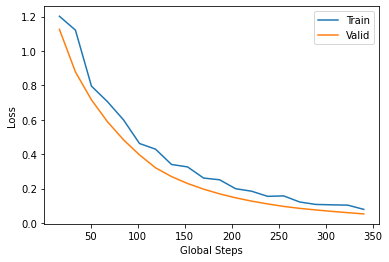

In [48]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(r'C:\Users\amest\Downloads\Git\modulo-2-rnn\rnn' + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

Se redefine la función de evaluación para el caso multiclase y se imprime nuevamente el reporte de clasificación y la matriz de confusión correspondiente

Model loaded from <== C:\Users\amest\Downloads\Git\modulo-2-rnn\rnn/model.pt
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       120
           1     1.0000    1.0000    1.0000       120
           2     1.0000    1.0000    1.0000       120
           3     1.0000    1.0000    1.0000       120

    accuracy                         1.0000       480
   macro avg     1.0000    1.0000    1.0000       480
weighted avg     1.0000    1.0000    1.0000       480



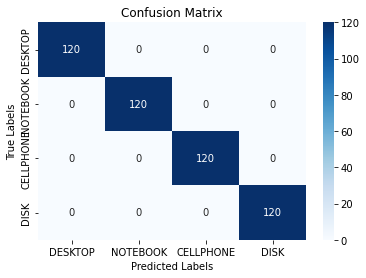

In [49]:
# Evaluation Function

def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for batch_no, batch in enumerate(test_loader):           
            title, title_len = batch.title
            labels = batch.domain_id
            labels = labels.to(device)
            title = title.to(device)
            title_len = title_len.to(device)
            output = model(title, title_len)

            output = (output > threshold).int()
            output = output.tolist()
            for i in range(0, len(output)):
                output[i] = np.argmax(output[i])
            y_pred.extend(output)
            y_true.extend(labels.tolist())


    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[0,1,2,3], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['DESKTOP', 'NOTEBOOK', 'CELLPHONE', 'DISK'])
    ax.yaxis.set_ticklabels(['DESKTOP', 'NOTEBOOK', 'CELLPHONE', 'DISK'])
    
    
best_model = LSTM(16, nclass=4).to(device)
optimizer = torch.optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(r'C:\Users\amest\Downloads\Git\modulo-2-rnn\rnn' + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

Con los parámetros dados, se obtuvo nuevamente una clasificación perfecta. Podría expandirse el tamaño del dataset con más clases para dificultar la clasificación o probar el mismo modelo con otro tipo de muestras, de forma de evaluar si estos resultados se pueden replicar en casos más complejos